# Josh Kelley BUAN 6341.003 Assignment 2

In [260]:
# import packages
#data analysis
import numpy as np
import pandas as pd

#OS stuff
import os
import glob
from time import time

#plotting Libs
import seaborn as sns
import matplotlib.pyplot as plt

#ML ScikitLearn
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,learning_curve
from sklearn.metrics import mean_squared_error,confusion_matrix, roc_curve,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pd.set_option('display.max_columns',54)
%matplotlib inline

### Load some of our functions which will be used later

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None, obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), figsize = (10,6)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
              A string (see model evaluation documentation)
              or a scorer callable object / function with signature scorer(estimator, X, y)
              For Python 3.5 the documentation is here:
              http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
              For example, Log Loss is specified as 'neg_log_loss'
              
    obj_line : numeric or None (default: None)
               draw a horizontal line 
               

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
        
    Citation
    --------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
        
    Usage
    -----
        plot_learning_curve(estimator = best_estimator, 
                            title     = best_estimator_title, 
                            X         = X_train, 
                            y         = y_train, 
                            ylim      = (-1.1, 0.1), # neg_log_loss is negative
                            cv        = StatifiedCV, # CV generator
                            scoring   = scoring,     # eg., 'neg_log_loss'
                            obj_line  = obj_line,    # horizontal line
                            n_jobs    = n_jobs)      # how many CPUs

         plt.show()
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt
    
    plt.figure(figsize = figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

def plot_learning_curves_nimb(param, train_scores,test_scores,ylim=None, xlabel='paramater range',  obj_line=None,title='learning curve', figsize = (10,6)):
    """Plot training and test scores in relation to a parameter setting"""

    plt.figure(figsize = figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlabel)
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(param, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(param, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param, train_scores_mean, 'o-', color="r",
             label="Training score via CV")
    plt.plot(param, test_scores_mean, 'o-', color="g",
             label="Testing Score via CV")

    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

# Load Facebook data 

#### Note we are only using Variant 1

In [3]:
colnames = ['page_pop',
           'page_check','page_talk_bt','page_cat','tot_min','tot_max','tot_avg','tot_med','tot_std','l24_min',
            'l24_max','l24_avg','l24_med','l24_std','l24_48_min','l24_48_max','l24_48_avg','l24_48_med','l24_48_std',
            'l48_72_min','l48_72_max','l48_72_avg','l48_72_med','l48_72_std','diff_24_48_min','diff_24_48_max','diff_24_48_avg',
            'diff_24_48_med','diff_24_48_std','num_comm_pre','num_comm_l24','num_comm_pre_24_48','num_comm_fir_24','num_comm_diff_24_48',
            'base_time','pst_len','pst_shre_cnt','pst_prom_stat','h_hours','pub_sun','pub_mon','pub_tue','pub_wed','pub_thu','pub_fri',
            'pub_sat','base_sun','base_mon','base_tue','base_wed','base_thu','base_fri','base_sat','comm_h_hours'
            ]

In [4]:
train_df = pd.read_csv('..\data\Dataset\Training\Features_Variant_1.csv', header=None)
test_df = pd.concat([pd.read_csv(f,header=None,nrows=1000)for f in glob.glob('..\data\Dataset\Testing\TestSet\Test_Case_*.csv')], ignore_index=True)

final_df = pd.concat([train_df,test_df])
final_df.head()

new_cols = dict(zip(train_df.columns,colnames))
final_df.rename(new_cols, axis='columns',inplace=True)

# Teleco Customer Churn Dataset

### Why is this dataset interesting, why is the classification interesting

we find this interesting because customer churn is a fascinating topic. What is it about a customer that causes them to churn? The ability to answer this questions and how to answer it is readily applicable in today's job market.

If we can find a way to prevent customer churn and show it to our managers, it will not only make us look good but keep us employed.

If we can find the attributes that help signal who is about to churn then we can provide the customer different offers to retain them.

Data is broken down on an individual customer basis and the types of service they have as well as how long they've been a customer

In [5]:
telco_df = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco_df.columns = [x.lower() for x in telco_df.columns]
telco_df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Feature Engineering on the dataset

Change our target varialbe from a yes/no to a 1/0. This ensures our algorithms can model them

Also, cleaning up other features a bit (yes/no --> 1/0) data a little bit to make it easier to get dummy varialbes and model.


In [6]:
#binary target conversion from yes/no to 1,0
telco_df['churn_bin'] = np.where(telco_df['churn'] == 'Yes',1,0)

#Feature engineering
telco_df.gender.replace(['Male', 'Female'], [1, 0], inplace=True)
telco_df.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
telco_df.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)
telco_df.phoneservice.replace(['Yes', 'No'], [1, 0], inplace=True)
telco_df.paperlessbilling.replace(['Yes', 'No'], [1, 0], inplace=True)
telco_df.paymentmethod.replace(to_replace=dict(zip(['Electronic check','Mailed check','Bank transfer (automatic)','Credit card (automatic)'],['echeck','mcheck','banktrans','cc'])), inplace=True)
telco_df.contract.replace(to_replace=dict(zip(['Month-to-month','One year','Two year'],['mtm','one_yr','two_yr'])), inplace=True)
telco_df.onlinesecurity.replace(to_replace=dict(zip(['No','Yes','No internet service'],['no','yes','nis'])) , inplace=True)
telco_df.onlinebackup.replace(to_replace=dict(zip(['No','Yes','No internet service'],['no','yes','nis'])) , inplace=True)
telco_df.deviceprotection.replace(to_replace=dict(zip(['No','Yes','No internet service'],['no','yes','nis'])) , inplace=True)
telco_df.techsupport.replace(to_replace=dict(zip(['No','Yes','No internet service'],['no','yes','nis'])) , inplace=True)
telco_df.streamingtv.replace(to_replace=dict(zip(['No','Yes','No internet service'],['no','yes','nis'])) , inplace=True)
telco_df.streamingmovies.replace(to_replace=dict(zip(['No','Yes','No internet service'],['no','yes','nis'])) , inplace=True)
telco_df.multiplelines.replace(to_replace=dict(zip(['no','yes','No phone service'],['no','yes','nps'])) , inplace=True)
telco_df.internetservice.replace(to_replace=dict(zip(['DSL' ,'Fiber optic', 'No'],['dsl','fiber','no'])) , inplace=True)
telco_df['totalcharges'] = pd.to_numeric(telco_df.totalcharges.str.strip(" "))

### Feature Engineering part2

1. Get dummies for our variables we replaced above. Again this is done so it's easier to train the model
2. We found a few null value with respect to total charges. Given that these null values have a tenure of 0 we are converting their monthly charges to total charges.


In [7]:
#one hot encoding
telco_df2 = pd.get_dummies(telco_df, columns = ['multiplelines','internetservice','onlinesecurity','onlinebackup', 'deviceprotection','techsupport','streamingtv','streamingmovies','contract','paymentmethod'],
                           drop_first=True)
telco_df2.isnull().any()
check_these = telco_df2[telco_df2.totalcharges.isnull()].index

In [8]:
telco_df2.totalcharges = np.where(telco_df2.totalcharges.isnull(), telco_df2.monthlycharges,telco_df2.totalcharges)
print(f'Our data has {telco_df2.shape[0]} rows and {telco_df2.shape[1]} columns')

Our data has 7043 rows and 33 columns


In [9]:
exclude_cols = ['churn','churn_bin','customerid']
X = telco_df2[telco_df2.columns[~telco_df2.columns.isin(exclude_cols)]].values
y = telco_df2['churn_bin'].values

# Telco Exploratory Analysis

 - 21 of our 31 variables % of our features are positvely correlated with our target variable. The other remaining are dummy variables
 - our least correlated variable is -23% which would be considered weakly classified
 - We will leave all the variables in as these attributes of the individual will be important to classify whether they churned or not
 - Our class balance is 73%/27%

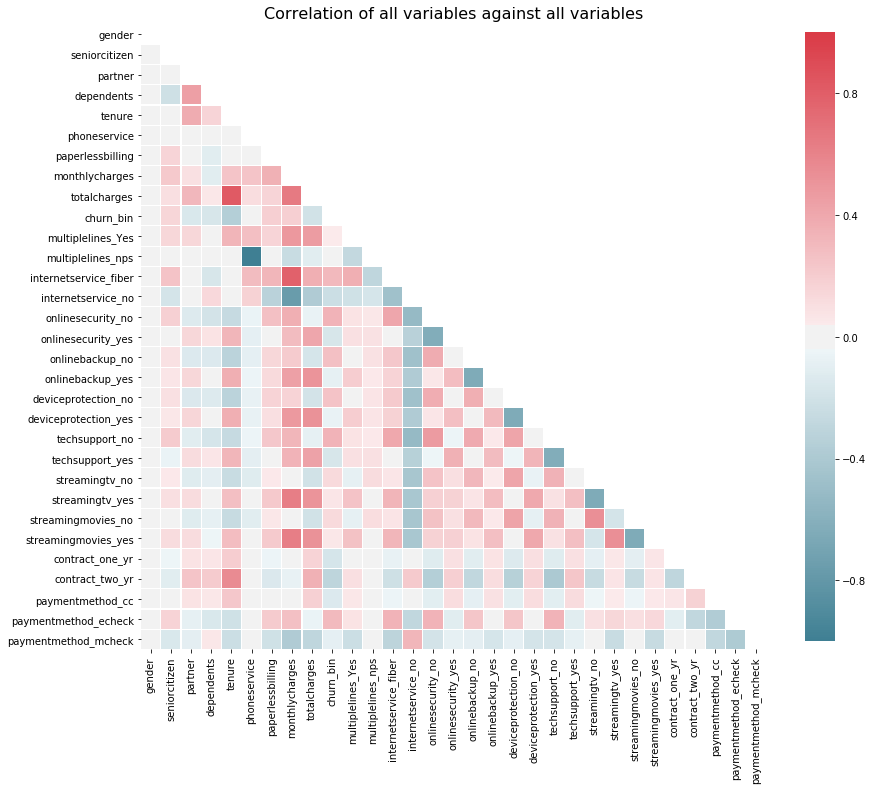

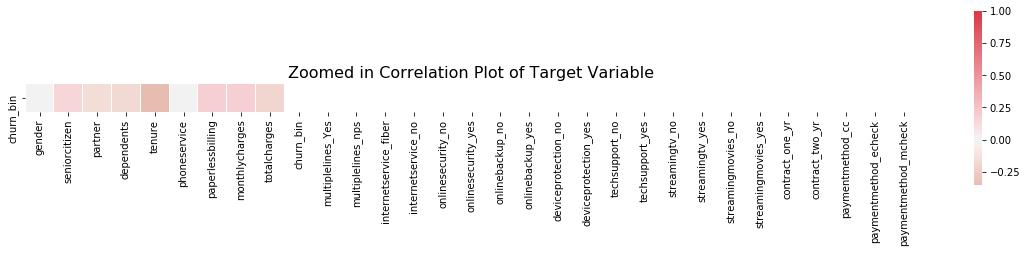

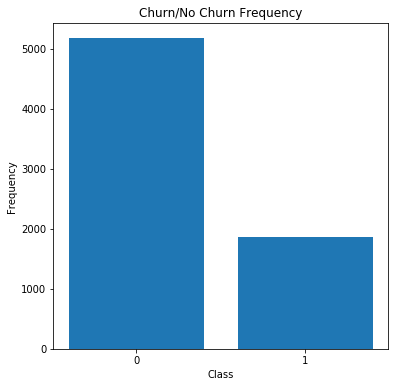

In [263]:
#telco_df2.loc[:,['page_pop', 'page_talk_bt', 'tot_avg', 'l24_avg', 'l24_48_avg', 'l48_72_avg', 'pst_len', 'pst_shre_cnt', 'comm_h_hours']].corr(method='pearson')
telcorr = telco_df2.corr(method='pearson')
mask = np.zeros_like(telcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('Correlation of all variables against all variables', fontsize = 16)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(telcorr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .8})


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 10, as_cmap=True)

ax.set_title("Zoomed in Correlation Plot of Target Variable", fontsize = 16)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(telcorr[9:10], mask=mask[9:10], cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.15, cbar_kws={"shrink": .8})

unique, counts = np.unique(telco_df2.churn_bin, return_counts=True)
plt.figure(figsize = (6,6))
plt.bar(unique,counts)
plt.title('Churn/No Churn Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0,1], unique)
plt.show()

## Train Test Split & PCA Telco

1. We first split our data into a 70/30 split of training and test as this is what we've done in clas.
1. Afte we split we are scaling ours features. Scaling the features is important as it optimizes computation time for our algorithms.
2. After we split and scale the data we then apply Principle Components Analysis to the data.
 - We are applying PCA to our data as it accomplishes a couple of things:
  - it reduces our dimensions from 33 dimensions to 15 dimensions (36% decrease) while still retaining 90% of the variance from our original data.
  - how it performs this is by taking variables which are correlated to each other and turns them into uncorrelated variables called principle components.
  - this is important as it will take less time to fit our model while still retaining the majority of the variance from our original data.


In [274]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .30, shuffle = True)

full_xscaler = StandardScaler().fit(x_train)
x_train_scaled = full_xscaler.transform(x_train)
x_test_scaled = full_xscaler.transform(x_test)

In [275]:
pca = PCA(n_components=30,random_state=20190301)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

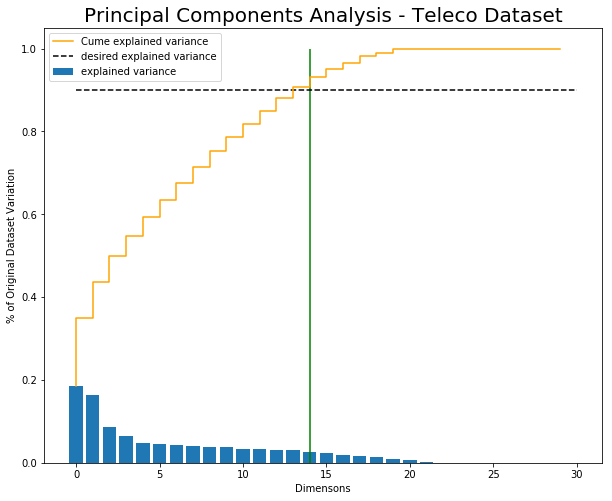

In [436]:
ratio_exp = .90
plt.figure(figsize = (10,8))
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, label='explained variance')
plt.step(range(0,len(pca.explained_variance_ratio_)), cum_var, label='Cume explained variance', color='orange')
plt.vlines(x = np.argmax(cum_var >= ratio_exp),ymin=0, ymax=1, color='green')
plt.hlines(y = ratio_exp,xmin = 0, xmax=30,linestyles = '--',label = 'desired explained variance')
plt.title('Principal Components Analysis - Teleco Dataset', fontsize=20)
plt.xlabel('Dimensons')
plt.ylabel('% of Original Dataset Variation')
plt.legend()

In [270]:
#we want 90% of the variation
pca = PCA(n_components=.90,random_state=20190301)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [271]:
x_train_pca.shape

(4930, 15)

# Notebook Wide Notes
## 1. We are trying to maximize our accuracy which is the inverse of minimizing error 
## 2. Optimal models are defined as a balance between accuracy (between +/-1std) and computation time

# Why is the teleco dataset interesting?
### The telco dataset is rather interesting due to customer churn being a curcial part of any business. We want to identify not only when but who will churm


1. This is a very applicable application in the job landscape today.
2. If we can bring tell a hiring manager that we have found ways to identify who will churn and accuratley predict this, we can leverage this in not only interviews but the real world


# Support Vector Machines  - Linear Experiment 1

### We are choosing to run a linear, RBF and polynomial model as these are some of the most popular SVM models

2. Experiment 1 - Linear search of Teleco dataset what is the optimal C parameter?
 - Since we need to find the optimal C parameter we will loop over 6 values to see which provides us optimal scores
3. Experiment 1 results:
 - We find that any C value >=.1 provides a cross validated accuracy score which are equivalent(+/-1 std within each other), meaning the accuracy of .1 is very similar to 1,10 and 100.
 - This is evident in both graph 1 and 2 below which shows the average of a 9 fold cross validation all have roughly a 79% accuracy on the training set and 81% accuracy on the test set

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

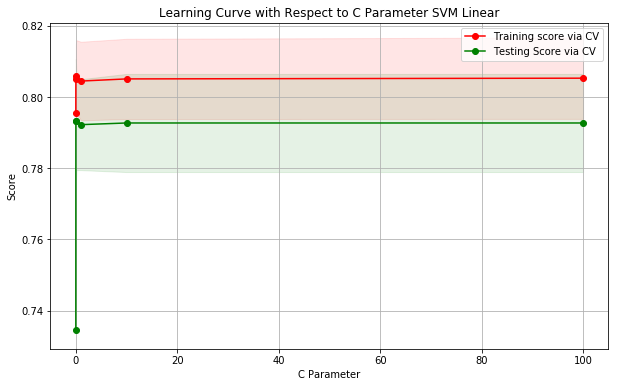

In [422]:
cv = 9
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores = np.zeros(shape=(len(param_range),cv))
test_scores = np.zeros(shape=(len(param_range),cv))
comp_time = []

for row, i in enumerate(param_range):
    start = time()
    svmclf = svm.SVC(C = i, kernel = 'linear')
    svmclf.fit(x_train_pca,y_train)
    score = svmclf.score(x_test_pca,y_test)
    train_scores[row,:] =cross_val_score(svmclf,x_train_pca,y_train,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(svmclf,x_test_pca,y_test,cv = cv, n_jobs = -1)
    end = time()
    comp_time.append(end-start)

plot_learning_curves_nimb(param_range, train_scores, test_scores, xlabel='C Parameter', title = 'Learning Curve with Respect to C Parameter SVM Linear')

Experiment 1 results Continued:
 - In the box &whiskey plot below you will see that C values between .01 thru 100 are nearly identical in their median(gold bar) and mean(green diamond). This process was done via 9 fold cross validation
 - Since the default parameter is 1 we are leaning towards choosing 1 but let's we need to run another experiment to see if any of these models suffer from bias or variance

FigureCanvasNbAgg()

Text(0.5, 0, 'C Parameter Value')

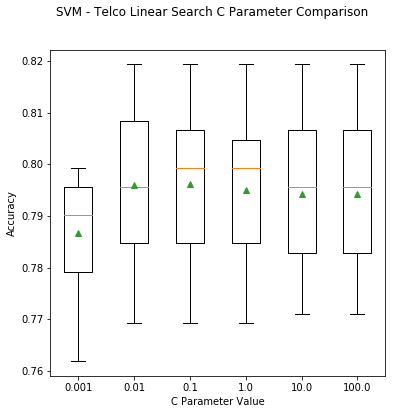

In [195]:
fig = plt.figure(figsize=(6,6))
fig.suptitle('SVM - Telco Linear Search C Parameter Comparison')
ax = fig.add_subplot(111)
plt.boxplot(train_scores.T,showmeans=True)
ax.set_xticklabels(param_range)
ax.set_ylabel('Accuracy')
ax.set_xlabel('C Parameter Value')

In [82]:
print('time to fit')
dict(zip(param_range, comp_time))

time to fit


{0.001: 3.0587329864501953,
 0.01: 1.0611698627471924,
 0.1: 1.2352144718170166,
 1.0: 2.6520800590515137,
 10.0: 10.518818378448486,
 100.0: 77.89686012268066}

# Support Vector Machines - Linear Experiment 2
1. Experiment 2 - Since the above showed we only really need to test 3 examples .001, 1 & 100 we will see which of these have the optimal bias/variance

2. Expierment Results:
 - Plot 1 - C parameter .001 both training and testing CV accuracy score are still improving as m increases - this tells us our margin is too wide and is underfitting the model to start and has high bias
 - plot 2 - C parameter 1 has low variance and low bias as m increases our training and CV converge - this is the model we will choose which is the default parameter
 - Plot 3 C parameter 100 has low variance and low bias as m increases our training and CV converge - this model also appears to work as well but we are choosing the default parameter becuase the default parameter takes 2secs to fit while this takes 77seconds to fit.
 
3. What is the C Parameter?
 - The C term is a regularization parameter it allows us to control maximizing the decision boundary margin with correct classification. As we increase C we are increasing the penalty of misclassification which results in a smaller margin. The smaller C parameter will allow for a wider margin and will have lower misclassification errors. This is our bias/variance control.  As a result, smaller C values will allow data points to enter into the margin. The goal of SVM is to create a linearly seperable hyperplace which perfectly fits our data while maximizing the margin between classes. In reality we seldom have a perfect seperation of classes, thus, the C parameter allows us a bias/variance tradeoff


#### In the linear SVM model we will choose the C parameter of 1 as it achieves low bias/low variance and takes 2 seconds to fit
 


FigureCanvasNbAgg()

FigureCanvasNbAgg()

FigureCanvasNbAgg()

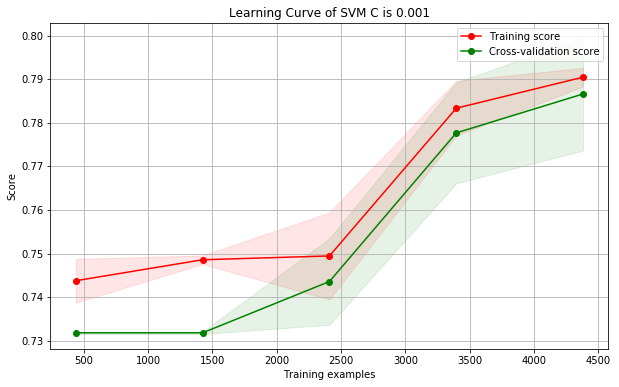

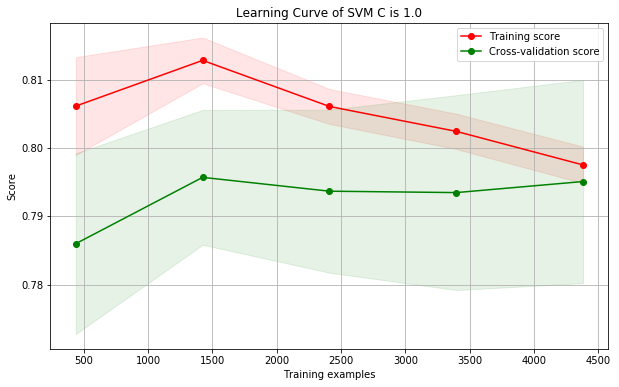

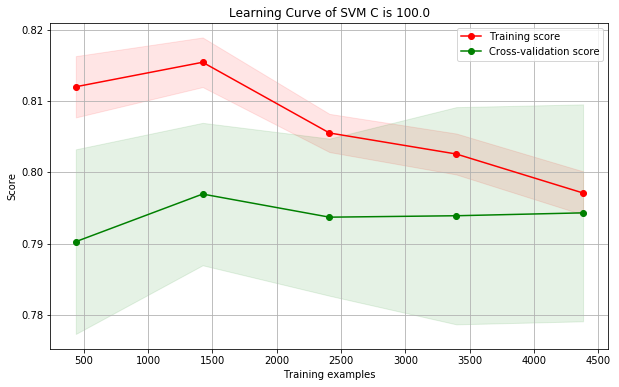

In [172]:
cv = 9
param_range = [0.001, 1.0, 100.0]

for i in param_range:
    svmclf = svm.SVC(C = i, kernel = 'linear')
    svmclf.fit(x_train_pca,y_train)
    plot_learning_curve(svmclf,'Learning Curve of SVM C is %s' %i ,x_train_pca, y_train,cv = cv,n_jobs=-1)

# Support Vector Machines  - Radial Basis Functions Experiment 1

1. Experiment 1 RBF - Search of C and Gamma parameter
 - Since we need to find the optimal C parameter we will loop over 6 values to see which provides us optimal scores at the same time we will loop over 10 gamma variables
 - To find the optimal gamma, we intially applied the same values in our C search [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] what we found is that values less than .5 provided the better accuracy scores
 - In the below you'll see our gamma space is 10 numbers between .0001 and .2 this is why we choose those numbers

In [60]:
############################################################################################
#
## Grid search do not run just here to show how i did it and that it was done
#
############################################################################################
grid_search_rbf = pd.DataFrame(columns = ['C', 'gamma', 'score','time', 'start_time'])
c_range = np.linspace(start = 1, stop = 10, num = 5)
gamma_space = np.linspace(start = .0001, stop = .2,num = 10)
for c in c_range:
    print(f'working on C {c}')
    for gam in gamma_space:
        print(f'working on gamma {gam}')
        start = time()
        svmclf = svm.SVC(C = c, kernel = 'rbf', gamma = gam)
        svmclf.fit(x_train_pca,y_train)
        score = svmclf.score(x_test_pca,y_test)
        end = time()
        grid_search_rbf = grid_search_rbf.append({'C': c,
                                        'gamma': gam,
                                        'score': score,
                                        'time':end-start,
                                        'start_time':start
                                       }, ignore_index=True)

working on C 1.0
working on gamma 0.0001
working on gamma 0.02231111111111111
working on gamma 0.04452222222222223
working on gamma 0.06673333333333334
working on gamma 0.08894444444444445
working on gamma 0.11115555555555556
working on gamma 0.13336666666666666
working on gamma 0.15557777777777776
working on gamma 0.17778888888888889
working on gamma 0.2
working on C 3.25
working on gamma 0.0001
working on gamma 0.02231111111111111
working on gamma 0.04452222222222223
working on gamma 0.06673333333333334
working on gamma 0.08894444444444445
working on gamma 0.11115555555555556
working on gamma 0.13336666666666666
working on gamma 0.15557777777777776
working on gamma 0.17778888888888889
working on gamma 0.2
working on C 5.5
working on gamma 0.0001
working on gamma 0.02231111111111111
working on gamma 0.04452222222222223
working on gamma 0.06673333333333334
working on gamma 0.08894444444444445
working on gamma 0.11115555555555556
working on gamma 0.13336666666666666
working on gamma 0.1

In [61]:
grid_search_rbf.sort_values(by='score', ascending = False).head(30)
#grid_search_rbf.to_csv('..\data\grid_search_rbf_telco.csv', index=False)

# Support Vector Machines  - Radial Basis Functions Experiment 1 Results
3. Experiment 1 RBF results:
 - We can see the following in our graph below:
        - we find that gamma values <=.025 AND a C value between 3-10 produce the best accuracy
        - C values 3-10 all start out with highest accuracys. As we begin to increase our gamma values, our accuracy decreases. Once we hit a gamma value of 0.125 our accuracy levels out
        - As the C value gets larger (i.e. the margin gets smaller) the accuracy decreases sequentially, i.e. C value of 3 > C value of 5 etc.
        - A C value of 1 produces interesting results completely different than the other C values. Our accuarcy peaks at a gamma value of .025 then we see a gentle decline in accuracy as gamma increases. THe reason this occurs is due to the width of our decision boundary. Our results are telling us a wider margin is more accurate at gamma levels >=.050
        
3. What is the gamma parameter?
 - The gamma parameter defines how far a single training examples influence reaches. Small gammas have a far reaching influence on the decision boundary while larger numbers only allow data points close to our decision boundary to have an influence. Our results show that we have better accuracy if we data points which are far out have an affect on the decision boundary

FigureCanvasNbAgg()

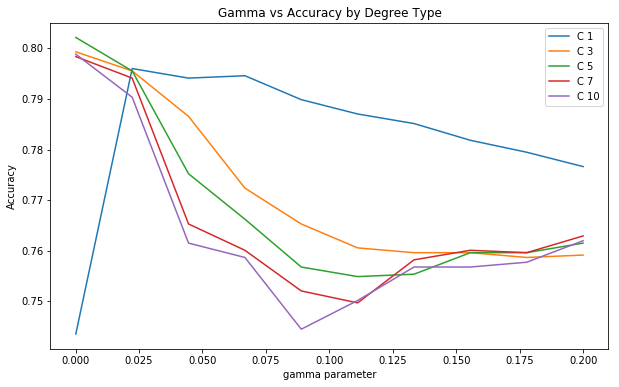

In [197]:
grid_search_rbf = pd.read_csv('..\data\grid_search_rbf_telco.csv')
plt.figure(figsize = (10,6))
for i in set(grid_search_rbf.C):
    plt.title('Gamma vs Accuracy by Degree Type')
    plt.plot(grid_search_rbf[grid_search_rbf.C ==i]['gamma'],grid_search_rbf[grid_search_rbf.C ==i]['score'], label = 'C %i' % i)
    plt.xlabel('gamma parameter')
    plt.ylabel('Accuracy')
    plt.legend()

# Support Vector Machines  - Radial Basis Functions Experiment 2 & Experiment 2 Results
3. Experiment 2 RBF: - The above plot showed us that a good gamma parameter is .025 and the different C parameters produce similar results. We need to test accuracy in realtion to the C parameter
 - We know that a value of .025 for gamma is optimal given our findings above but does a large or C parameter have better results via 9 fold cross validation

4. Experiment 2 RBF Results:
     - Our training and testing accuracy are similar between 1 and 3. After a C parameter of 3 we begin to lose 2ppts of accuarcy. 
     - It appears that our decision boundary is becomes smaller and smaller (as C increases) we begin to misclassify more often hence our accuracy decreases


<module 'matplotlib.pyplot' from 'C:\\Users\\JOSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

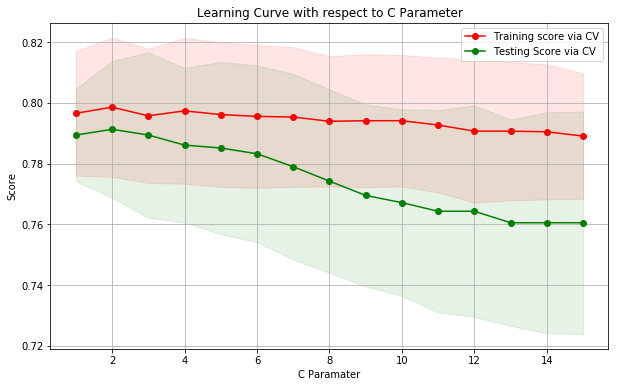

In [16]:
cv = 9
param_range = np.linspace(start = 1, stop = 15,num = 15)
train_scores = np.zeros(shape=(len(param_range),cv))
test_scores = np.zeros(shape=(len(param_range),cv))
for row, c in enumerate(param_range):
    svmclf = svm.SVC(C = c, kernel = 'rbf', gamma = .025)
    svmclf.fit(x_train_pca,y_train)
    train_scores[row,:] =cross_val_score(svmclf,x_train_pca,y_train,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(svmclf,x_test_pca,y_test,cv = cv, n_jobs = -1)
plot_learning_curves_nimb(param_range, train_scores, test_scores, xlabel='C Paramater', title='Learning Curve with respect to C Parameter')

# Support Vector Machines  - Radial Basis Functions Experiment 3
3. Experiment 3 RBF: - Given that our optimal gamma parameter is .025 are which C Parameter between 1&3  have the best bias/variance trade off?
 - We know that a value of .025 for gamma is optimal(most accurate in least amount of time) but does the a large or C parameter have better results via 9 fold cross validation and what is the bias variance trade off?

4. Experiment 3 RBF Results:
 - plot 1
    - this is our default value and has a good bias/variance trade off. Training and testing accuracy improve and gets close to converging as M improves. Training accuracy = 80%, testing accuracy = 79%. gap = 1ppt.
 - plot 2:
    - this also has a good bias/variance trade off. Training and testing accuracy improve and gets close to converging but not as much as plot 1. Training accuracy = 82%, testing accuracy = 80%. gap = 2ppts
 - plot 3:
    - this also has a good bias/variance trade off. Training and testing accuracy improve and gets close to converging but not as much as plot 1. Training accuracy = 82%, testing accuracy = 79%. gap = 3ppts    
 - In comparing the 3 plots we can also see the effect of the C regularization parameter, as  parameter increases our shaded green area (test CV error) becomes smaller and smaller. 
 
### In the end our best RBF parameters are C = 1 gamma = .0223 due to gap between training/testing accuracy

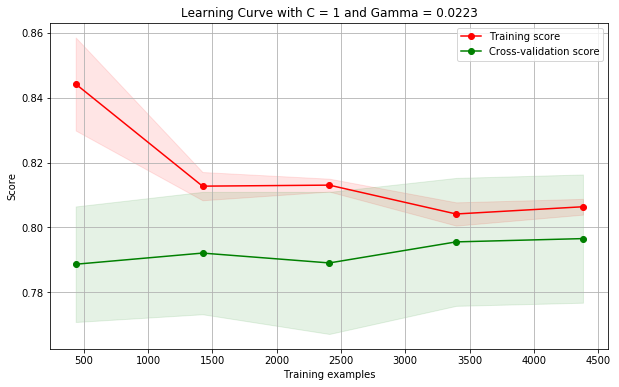

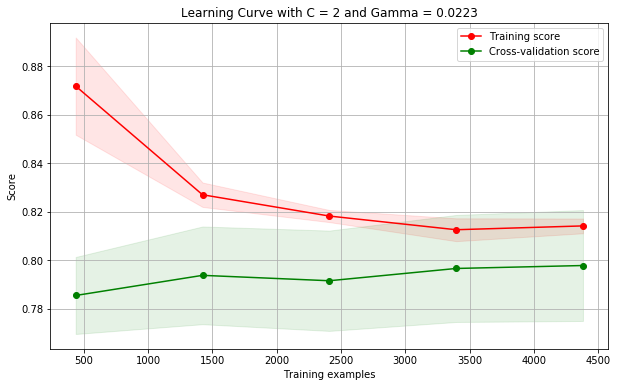

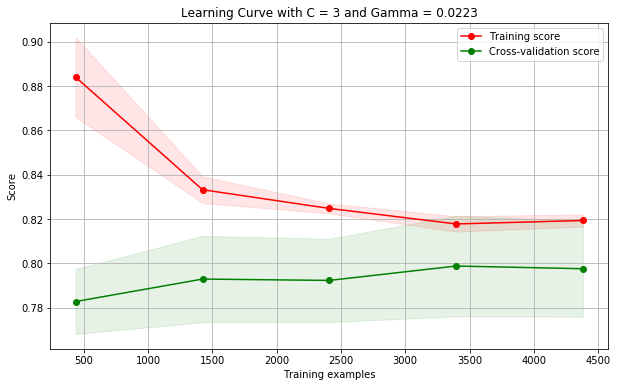

In [39]:
cv = 9
c_values = [1,2,3]
for i in c_values:
    svmclf = svm.SVC(C = i, kernel = 'rbf', gamma = .0223)
    svmclf.fit(x_train_pca,y_train)
    plot_learning_curve(svmclf,title = f'Learning Curve with C = {i} and Gamma = 0.0223',X= x_train_pca,y= y_train,cv = cv,n_jobs = -1)

# Support Vector Machines  - Polynominal Experiment 1

1. Experiment 1 Poly - Search of C,  Gamma  & Degree parameter
 - Since we need to find the optimal C, gamma and degree parameter we will loop over the product of 3 different parameter lists to see which provides us optimal accuracy.
 - Initially we will fit the model to the training set then score our models with the testing dataset to produce an fairly unbiased assesment of our fit.
 - Once we have a number of models we will evalute them and perform other experiments.


In [73]:
############################################################################################
#
# Grid search do not run just here to show how i did it and that it was done
# if you need to run open the csv file
#
############################################################################################
grid_search_poly_tel = pd.DataFrame(columns = ['degrees','C', 'gamma', 'score','time', 'start_time'])
c_range = np.linspace(start = 1, stop = 10, num = 5)
gamma_space = np.linspace(start = .0001, stop = .2,num = 10)
degrees = [3,4,5]
for d in degrees:
    print(f'working on {d} degrees')
    for c in c_range:
        print(f'working on {c} C')
        for gam in gamma_space:
            start = time()
            svmclf = svm.SVC(C = c, kernel = 'poly',degree=d, gamma = gam)
            svmclf.fit(x_train_pca,y_train)
            score = svmclf.score(x_test_pca,y_test)
            end = time()
            grid_search_poly_tel = grid_search_poly_tel.append({'degrees': d,
                                                    'C': c,
                                                    'gamma': gam,
                                                    'score': score,
                                                    'time':end-start,
                                                    'start_time':start
                                                   }, ignore_index=True)

working on 3 degrees
working on 1.0 C
working on 3.25 C
working on 5.5 C
working on 7.75 C
working on 10.0 C
working on 4 degrees
working on 1.0 C
working on 3.25 C
working on 5.5 C
working on 7.75 C
working on 10.0 C
working on 5 degrees
working on 1.0 C
working on 3.25 C
working on 5.5 C
working on 7.75 C
working on 10.0 C


In [328]:
grid_search_poly_tel = pd.read_csv('..\data\grid_search_poly_telco.csv')
grid_search_poly_tel['time_per_score'] = (grid_search_poly_tel['time']**(1/2))/(grid_search_poly_tel['score']**4) #adding more weight to score and less weight to the time to all higher scores to the top

# Support Vector Machines  - Polynominal Experiment 1 Results

1. Experiment 1 Polynominal - Results
 - Across all degrees a gamma parameter of .0223 has the highest score on the testing set. 
  - Plot 1:
    - with polynominal 3, accuracy increases as the gamma value hits .0223 then accuaracy falls and levels out past a gamma parametr o 0.125. This is true across all C values in this plot
  - Plot 2:
    - with polynomial 4, accuracy increases as the gamma value hits .0223 then accuaracy falls and levels out past a gamma parametr o 0.125. This is true across all C values in this plot
  - Plot 3:
    - with polynomial 5,  accuracy increases as the gamma value hits .0223 then accuaracy falls and levels out past a gamma parametr o 0.125. This is true across all C values in this plot

- These 3 plots imply that after taking into a higher dimenson we still need to rely on a large margin. The larger margin allows data points to enter into our margin while allowing data points which are far from the hyperplane to have an influence on the hyperplane
 - A c value of 3 appears to have the highest accuracy across all polynomial degrees. We will next run another test with C = 3 and gamma = 0.0223
 - As the polynominal increases the accuracy variance increases, Poly 3 accuracy range = [.74,.80] while Poly 4 &5 accuracy range = [.70,.80]

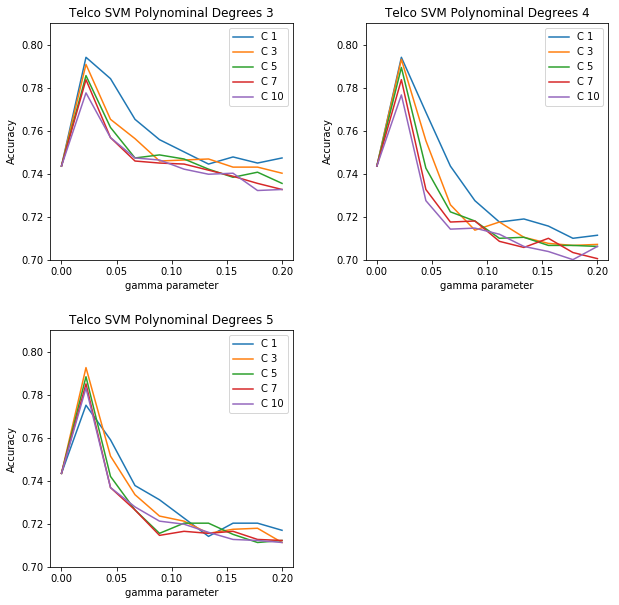

In [300]:
telfig = plt.figure(figsize = (10,10))
telfig.subplots_adjust(hspace=.3, wspace=.3)
for d in range(1,4):
    dat = grid_search_poly_tel[grid_search_poly_tel.degrees == d+2]
    ax = telfig.add_subplot(2, 2,d)
    #ax = fig.subplots(2,2,i,sharex = 'col',sharey='row')
    dval = d+2
    #ax.text(0.5, 0.5, str((2, 2, i)),fontsize=18, ha='center')
    for c in set(dat.C):
        ax.set_title('Telco SVM Polynominal Degrees %i' % dval)
        ax.plot(dat[dat.C ==c]['gamma'],dat[dat.C ==c]['score'], label = 'C %i' % c)
        ax.legend()
        ax.set_ylabel('Accuracy')
        ax.set_ylim(bottom =.7, top=.81)
        ax.set_xlabel('gamma parameter')

# Support Vector Machines  - Polynominal Experiment 2 & Results
1. Experiment 2 Polynominal - 9 fold cross validation of Learning Curve
 - The optimal C parameter is 3 and optimal gamma parameter is .0223
 

2. Experiment 2 Polynominal Results - 9 fold cross validation of Learning Curve
 - As we increase the complexity or add more polynomial terms, we introduce more variance into the learing curve. This is evident in our plots where degrees are >=4 and their accuracy scores don't converge but rather mirror each other. In an ideal learning curve we should see a large gap between training and testing where m is 1 but as m increases we should see these two lines converge. We don't see that when degrees >=4
 - In the end the best fitting polynomial model has a degree of 3 a C parameter of 3 ad a gamma of .0223. This is the best fitting model becuase it give us the highest 9 fold testing accuracy (79%) at the same time training and testing accuracy converge as m increases
 
#### Our best parameters for polynomial fitting it Degree = 3, C = 3, Gamma = .0223


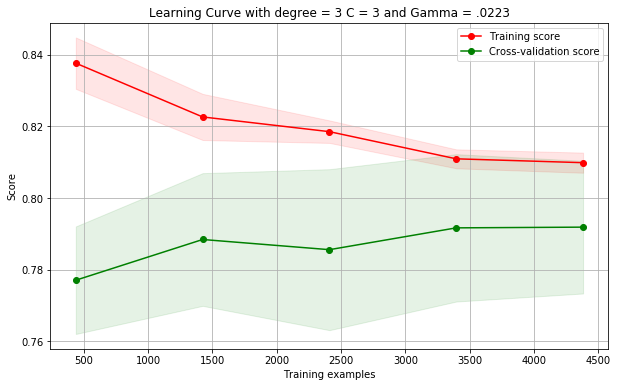

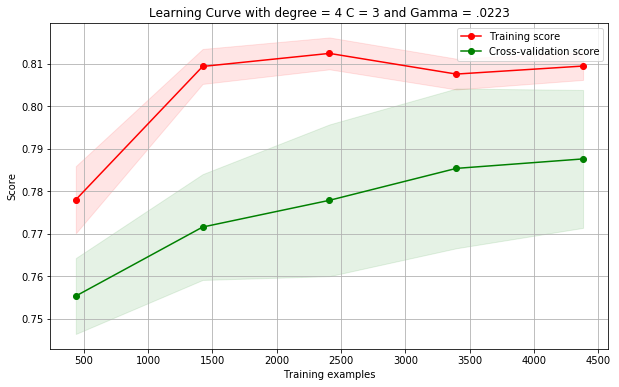

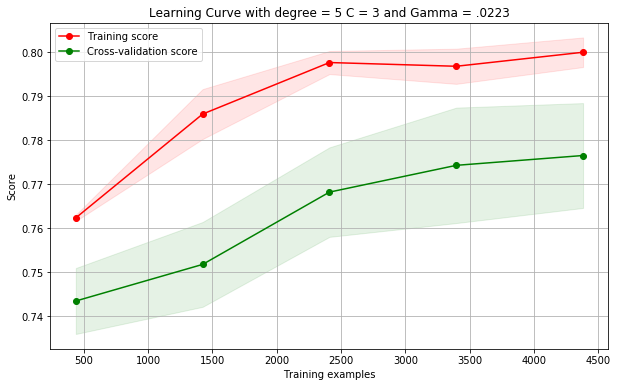

In [34]:
cv = 9
degree = [3,4,5]
for deg in degree:
    svmclf = svm.SVC(C = 3, kernel = 'poly',degree=deg, gamma= .0223)
    svmclf.fit(x_train_pca,y_train)
    plot_learning_curve(svmclf,title = f'Learning Curve with degree = {deg} C = 3 and Gamma = .0223',X= x_train_pca,y= y_train,cv = 9,n_jobs = -1)

## SVM - Telco Final Model Comparison

1. We choose these three models as a way to get models with different complexity (least complex =  Linear to most complex = polynominal.) These are also the most popular SVMs as well.
1. Comparing the SVM models against each other we see they all perform the same as their accuracies are similar to each other and their accuracy distribution overlap, as well.

Text(0,0.5,'Accuracy')

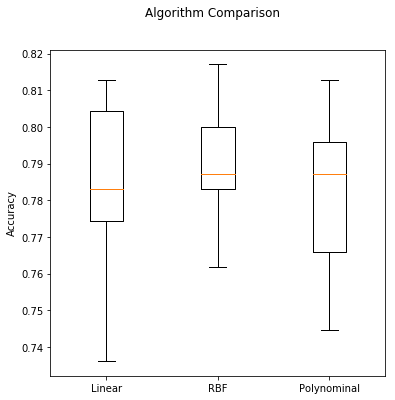

In [41]:
cv =9
tel_svm_results = []
computation_time = []


#Best Linear Model
start = time()
svmtel = svm.SVC(C = 1, kernel = 'linear', probability=True)
svmtel.fit(x_train_pca,y_train)
tel_svm_results.append(cross_val_score(svmtel, x_test_pca, y_test, cv=cv, scoring='accuracy'))
end= time()
computation_time.append((end-start)/60)


#Best RBF Model
start = time()
svmclf_rbf = svm.SVC(C = 1, kernel = 'rbf', gamma = .0223, probability=True)
svmclf_rbf.fit(x_train_pca,y_train)
tel_svm_results.append(cross_val_score(svmclf_rbf, x_test_pca, y_test, cv=cv, scoring='accuracy'))
end= time()
computation_time.append((end-start)/60)

#Best Poly Model
start = time()
svmclf_p = svm.SVC(C = 3, kernel = 'poly',degree=3, gamma = .0223, probability=True)
svmclf_p.fit(x_train_pca,y_train)
tel_svm_results.append(cross_val_score(svmclf_p,  x_test_pca, y_test,cv=cv, scoring='accuracy'))
end= time()
computation_time.append((end-start)/60)


#Plot the best results
my_names = ['Linear', 'RBF','Polynominal']
fig = plt.figure(figsize=(6,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(tel_svm_results)
ax.set_xticklabels(my_names)
ax.set_ylabel('Accuracy')

# SVM - Telco Final Model Comparison Continued

1. Next we will plot the ROC cuver comparing the above 3 models.
2. We want to find the curve the hugs the left hand side and upper left hand side the best. 

We conclude the linear SVM models is the best as the blue line below in the ROC curve is closer to the top left of the ROC Curve. The linear model has higher True positive rates when the False positive rate is >=.4. Also the Linear model is more simple and takes 2 seconds to fit.

#### We conclude our optial model to be the linear SVM model with default parameters

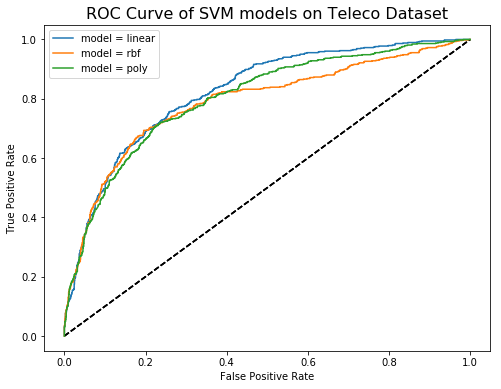

In [37]:
models = {'linear': svmtel, 'rbf': svmclf_rbf,'poly':svmclf_p}
plt.figure(figsize = (8,6))
for leg, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test_pca)[:,1])
    plt.title('ROC Curve of SVM models on Teleco Dataset', fontsize = 16)
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label = f'model = {leg}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

# Decision Trees for Telco - Experiment 1 

#### Experiment 1 - Pruning the tree
1. Which depth value of the tree gives us an optimal accuarcy score?
 - optimal is defined by highest accurary while still being able to generalize (i.e. low bias/low variance) and has a low computation time

#### Conclusion
 - After a depth of 3 both training and testing scores via 9 fold CV both begin to sequentially decrease in accuracy and the accuracy gap between training and testing increases as well
 - the below chart tells us that as we increase the depth of the tree our accuracy suffers in both training and testing. Our decision tree is getting too deep or too specific (high variance) and is actually performing worse than a tree that is shorter

<module 'matplotlib.pyplot' from 'C:\\Users\\JOSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

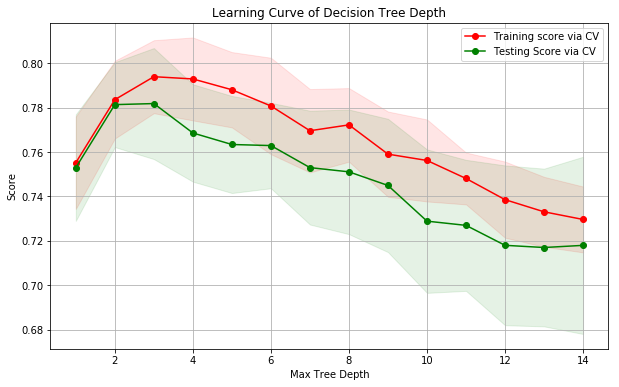

In [43]:
cv = 9
depth_range = range(1,15)
train_scores = np.zeros(shape=(len(depth_range),cv))
test_scores = np.zeros(shape=(len(depth_range),cv))
for row, i in enumerate(depth_range):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(x_train_pca,y_train)
    train_scores[row,:] =cross_val_score(clf,x_train_pca,y_train,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(clf,x_test_pca,y_test,cv = cv, n_jobs = -1)
    
plot_learning_curves_nimb(depth_range, train_scores, test_scores, title=f'Learning Curve of Decision Tree Depth', xlabel='Max Tree Depth')


# Decision Trees for Telco - Experiment 2

#### Experiment 2 - learning curve for our pruned tree(max depth =3)
1. Does our findings above conclude that we have a model which deals with the bias/variance trade off

#### Conclusion
 - Yes, we can conclude we have low bias/ low variance with our depth estimates
 - we seen in the chart below the gap between training and testing accuracy decreases as M increases. Gap between training and 9 fold cv is 2ppts where m is roughly 4500 samples

<module 'matplotlib.pyplot' from 'C:\\Users\\JOSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

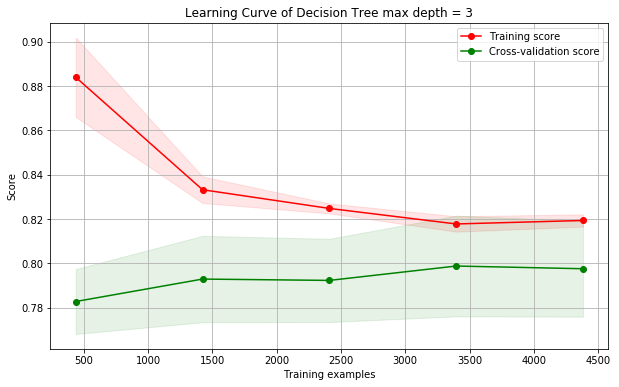

In [45]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(x_train_pca,y_train)
plot_learning_curve(svmclf,'Learning Curve of Decision Tree max depth = 3',x_train_pca, y_train, cv = 9,n_jobs=-1)

# Decision Trees for Telco - Experiment 3

#### Experiment 3 - Minimum number of Samples per leaf
1. how does the minimum number of samples per leaf effect our accuracy?

#### Conclusion
 - The minimum number of samples per leaf does not have an effect on accuracy
 - Training error and testing error stay achieve a consistent accuracy as min samples per leaf increase
 - results computed via 9 fold cross validation
 
#### In the end we will leave this hyperparameter at the default value of 5

In [53]:
cv = 9
min_features = range(1,50, 5)
#min_features = np.linspace(.0001,.1,num = 30)
train_scores = np.zeros(shape=(len(min_features),cv))
test_scores = np.zeros(shape=(len(min_features),cv))
for row, i in enumerate(min_features):
    clf = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=i,random_state = 20190301,)
    clf.fit(x_train_pca,y_train)
    train_scores[row,:] =cross_val_score(clf,x_train_pca,y_train,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(clf,x_test_pca,y_test,cv = cv, n_jobs = -1)

<module 'matplotlib.pyplot' from 'C:\\Users\\JOSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

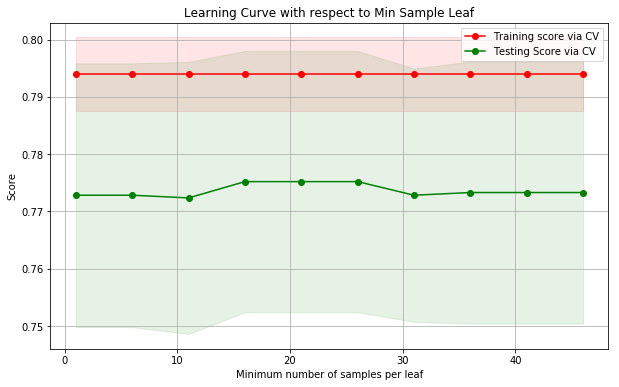

In [52]:
plot_learning_curves_nimb(min_features, train_scores, test_scores,title = 'Learning Curve with respect to Min Sample Leaf', xlabel='Minimum number of samples per leaf')

# Decision Trees for Telco - Experiment 4

#### Experiment 4 - Maximum Features
1. how does the max features affect the accuracy of our classification and how is the bias/variance trade off?

#### Conclusion
 - The max features used improves as we add more features up to the maximum number of dimenson in our dataset
 - This makes sense as we used PCA to reduce the dimensonality of our data while maintaining 90% of the variance of the original data
 
#### In the end the default parameter of all variables is choosen

<module 'matplotlib.pyplot' from 'C:\\Users\\JOSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

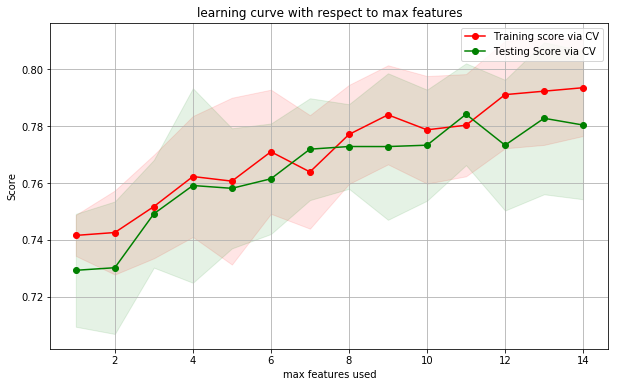

In [55]:
cv = 9
max_feature_range = range(1, x_train_pca.shape[1])
train_scores = np.zeros(shape=(len(max_feature_range),cv))
test_scores = np.zeros(shape=(len(max_feature_range),cv))

for row, i in enumerate(max_feature_range):
    clf = tree.DecisionTreeClassifier(max_depth=3,max_features=i)
    clf.fit(x_train_pca,y_train)
    train_scores[row,:] =cross_val_score(clf,x_train_pca,y_train,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(clf,x_test_pca,y_test,cv = cv, n_jobs = -1)

plot_learning_curves_nimb(max_feature_range, train_scores, test_scores,xlabel='max features used', title= 'learning curve with respect to max features')

# Decision Trees for Telco - Experiment 4 continued

#### Experiment 4 - Maximum Features
1. we want to ensure that the learning curve with respect to sample size does not suffer from high bias/or high variance

#### Conclusion
 - We have a model which generalizes well. As the number of samples increase the training and 9 fold ross validation accuracy converges
 
#### In the end we conclude the default parameter of max features, which is all featues, as it generalizes well

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

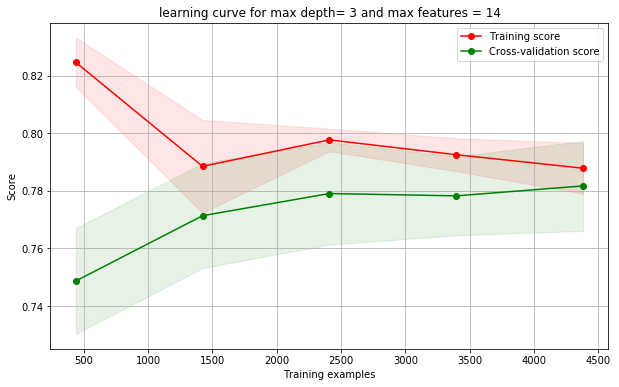

In [423]:
clf = tree.DecisionTreeClassifier(max_depth=3, max_features=14)
plot_learning_curve(clf,'learning curve for max depth= 3 and max features = 14',x_train_pca, y_train,cv = 9, n_jobs=-1)

# Decision Trees for Telco - Experiment 5 - Gini vs Entropy

#### Experiment 5 - Does Gini impurity or Entropy give us better out of fit error
1. We want to pick the criterion that maximizes the classification accuracy

#### Conclusion
 - Based on the below chart, both criterion produce accuracys which are equal to each other Gini impurity 9 fold mean accuracy = 77%, entropy 9 fold mean accuracy  = 77%
 - since both are the same we are choosing the default value of gini impurity

Text(0,0.5,'Accuracy')

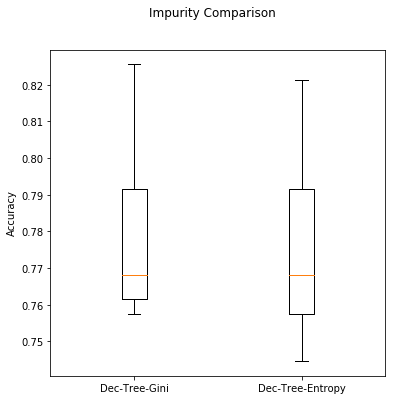

In [59]:
clf_crit = []
cv = 9
#gini
clf_g = tree.DecisionTreeClassifier(max_depth=3,criterion='gini')
clf_g.fit(x_train_pca,y_train)
clf_crit.append(cross_val_score(clf_g,  x_test_pca, y_test,cv=cv, scoring='accuracy'))

#entropy
clf_ent = tree.DecisionTreeClassifier(max_depth=3,criterion='entropy')
clf_ent.fit(x_train_pca,y_train)
clf_crit.append(cross_val_score(clf_ent,  x_test_pca, y_test,cv=cv, scoring='accuracy'))

#Plot the best results
my_names = ['Dec-Tree-Gini','Dec-Tree-Entropy']
fig = plt.figure(figsize=(6,6))
fig.suptitle('Impurity Comparison')
ax = fig.add_subplot(111)
plt.boxplot(clf_crit)
ax.set_xticklabels(my_names)
ax.set_ylabel('Accuracy')

# Boosting (Adaboost) for Telco - Experiment 1 

#### Experiment 1 - Base estimator param search
1. Which base estimator value of the boosted tree gives us an optimal accuarcy score?
 - optimal is defined by highest accurary while still being able to generalize (i.e. low bias/low variance)
 - we approach this by looping over several estimators and perform 9 fold cross validation

#### Conclusion
 - we conclude our best estimator will be between 10 and 50 as the below chart shows that our testing score is closest to training scores at this point AND is the highest training score
 - Once we begin to move past 50 estimators we see the training accuracy flat line while the testing accuracy sees a sequential decrease in accuracy


<module 'matplotlib.pyplot' from 'C:\\Users\\JOSH\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

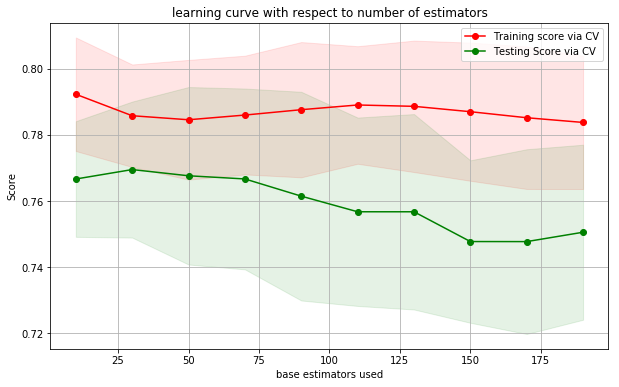

In [62]:
cv = 9
estimator = range(10,200,20)
train_scores = np.zeros(shape=(len(estimator),cv))
test_scores = np.zeros(shape=(len(estimator),cv))
comp_time = np.zeros(shape=(len(estimator),1))

for row, i in enumerate(estimator):
    start = time()
    adaclf = AdaBoostClassifier(n_estimators=i)
    adaclf.fit(x_train_pca, y_train)
    train_scores[row,:] =cross_val_score(adaclf,x_train_pca,y_train,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(adaclf,x_test_pca,y_test,cv = cv, n_jobs = -1)
    end = time()
    comp_time[row,:] = (end-start)/60

plot_learning_curves_nimb(estimator, train_scores, test_scores,xlabel='base estimators used', title= 'learning curve with respect to number of estimators')

# Boosting (Adaboost) for Telco - Experiment 2 Learning Curves of best estimators above

#### Experiment 1 - Base estimator learning cuves
1. Which base estimator value of the boosted tree gives us the best generalization ie which model has the best bias/variance trade off


#### Conclusion
 - A base estimator of 10(first plot) is the best estimator to use. As we increase m the accuracy between training and testing begins to converge. This implies that our model has low bias and low variance
 - the other two plots (learning curve of 30 & 50 estimators) produce similar results but we do not see the convergence that we see in the first plot. Simple heuristics says 10 estimators takes less time to fit vs 30 and 50
 - All estimators have similar training(80%) and testing accuracy's(79%), there fore we will use the simpler model with n_estimator of 10


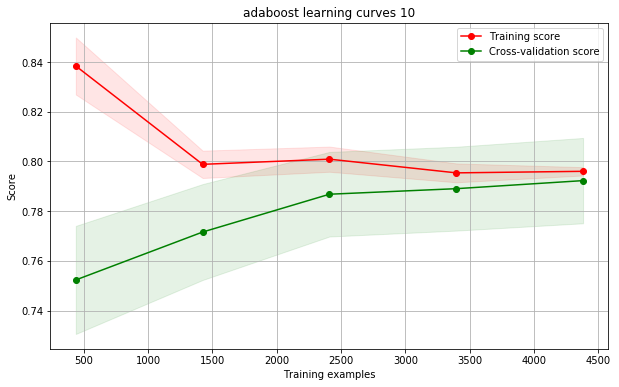

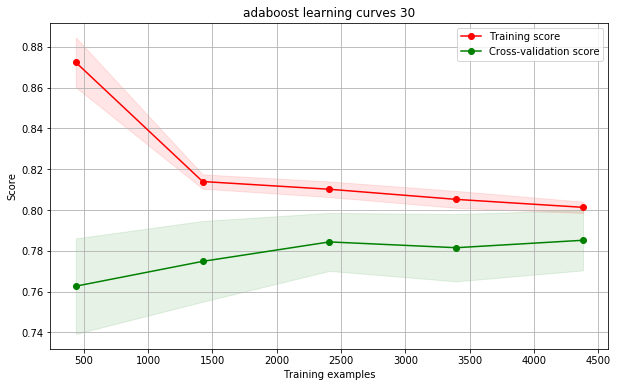

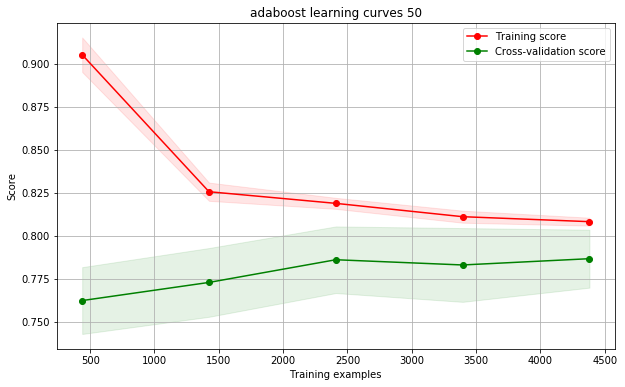

In [63]:
cv = 9
estimator = [10, 30, 50]
for i in estimator:
    adaclf = AdaBoostClassifier(n_estimators=i)
    adaclf.fit(x_train_pca, y_train)
    plot_learning_curve(adaclf,f'adaboost learning curves {i}', x_train_pca, y_train, cv = cv, n_jobs = -1)

In [117]:
cv = 9
tel_all_model_results = []

#Best Linear Model
svmtel = svm.SVC(C = 1, kernel = 'linear', probability=True)
svmtel.fit(x_train_pca,y_train)
tel_all_model_results.append(cross_val_score(svmtel, x_test_pca, y_test, cv=cv, scoring='accuracy'))

#Best RBF Model
svmclf_rbf = svm.SVC(C = 1, kernel = 'rbf', gamma = .0223, probability=True)
svmclf_rbf.fit(x_train_pca,y_train)
tel_all_model_results.append(cross_val_score(svmclf_rbf, x_test_pca, y_test, cv=cv, scoring='accuracy'))

#Best Poly Model
svmclf_p = svm.SVC(C = 3, kernel = 'poly',degree=3, gamma = .0223, probability=True)
svmclf_p.fit(x_train_pca,y_train)
tel_all_model_results.append(cross_val_score(svmclf_p,  x_test_pca, y_test,cv=cv, scoring='accuracy'))

#best Decision tree
clf_dt_p = tree.DecisionTreeClassifier(max_depth=3)
clf_dt_p.fit(x_train_pca,y_train)
tel_all_model_results.append(cross_val_score(clf_dt_p,  x_test_pca, y_test,cv=cv, scoring='accuracy'))

#best Boosted Tree
adaclf_tel = AdaBoostClassifier(n_estimators=10)
adaclf_tel.fit(x_train_pca, y_train)
tel_all_model_results.append(cross_val_score(adaclf_tel,  x_test_pca, y_test,cv=cv, scoring='accuracy'))


# Teleco - Final Model Comparison

#### In the end we would choose the SVM - Linear model as the best model.

1. Reasons for picking this model
 - This model has the highest accuracy rate 80%(plot 1). 
 - This is model takes 2.65 seconds to fit (This information is back up in the Linear SVM section)
 - This model not only has a ROC curve which hugs the top left better than the other models but also produces the highest auc score of 83.5%(plot 2 titled ROC Curve of All tested models on Telco Dataset)

Text(0, 0.5, 'Accuracy')

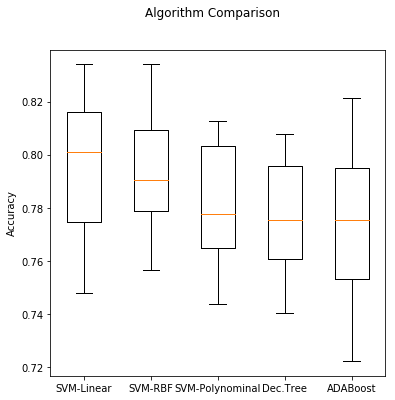

In [118]:
#Plot the best results
my_names = ['SVM-Linear', 'SVM-RBF','SVM-Polynominal', 'Dec.Tree','ADABoost']
fig = plt.figure(figsize=(6,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(tel_all_model_results)
ax.set_xticklabels(my_names)
ax.set_ylabel('Accuracy')

linear-SVM had an auc score of 0.8346479914435811
rbf-SVM had an auc score of 0.7898998081097234
poly-SVM had an auc score of 0.8108785383982778
Dec.Tree had an auc score of 0.8097865164499849
Adaboost had an auc score of 0.8201129770855148


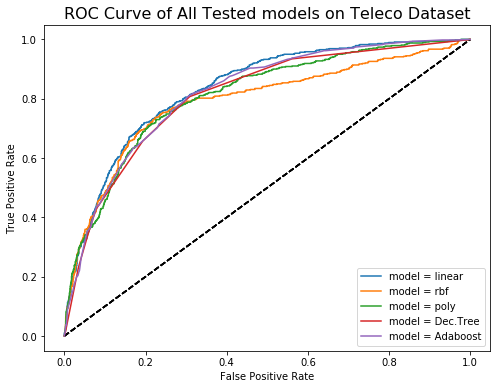

In [119]:
models = {'linear': svmtel, 'rbf': svmclf_rbf,'poly':svmclf_p,'Dec.Tree':clf_dt_p,'Adaboost':adaclf_tel}
plt.figure(figsize = (8,6))
for leg, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test_pca)[:,1])
    plt.title('ROC Curve of All Tested models on Teleco Dataset', fontsize = 16)
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label = f'model = {leg}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

models = {'linear-SVM': svmtel, 'rbf-SVM': svmclf_rbf,'poly-SVM':svmclf_p,'Dec.Tree':clf_dt_p,'Adaboost':adaclf_tel}
for leg, model in models.items():
    auc_score = roc_auc_score(y_test, model.predict_proba(x_test_pca)[:,1])
    print(f'{leg} had an auc score of {auc_score}')

# Facebook Data Begins Here

# Convert Facebook Data to Binary Classification

1. Addition of num_comm_l24h^2.
 - Num_comm_l24 is + correlated with the target variable adding in the squared term to account for a quadratic fit. 

1. Converting from continuous to binary
 - we are saying if there is 1 or more comments in the last H hours  then we will classify it as 1 else 0

In [15]:
final_df['num_comm_l24_sq'] = final_df['num_comm_l24']**2
final_df['comm_h_hour_bin'] = np.where(final_df['comm_h_hours'] >0 ,1,0)
final_df2 = final_df.drop(columns = 'comm_h_hours')
X_fb = final_df2.iloc[:,:-1].values
y_fb = final_df2.iloc[:,-1].values

# Facebook Exploratory Analysis

 - 73% of our features are positvely correlated with our target variable
 - our least correlated variable is -23% which would be considered weakly classified
 - We will leave all the variables in as they add important information with respect to target
 - Our class balance is 55%/45%

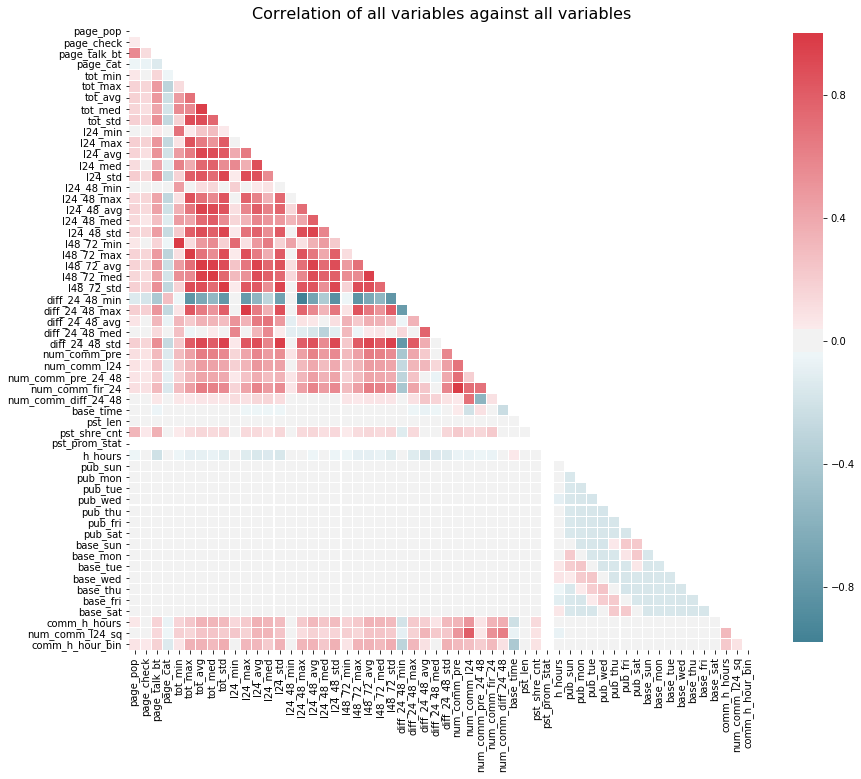

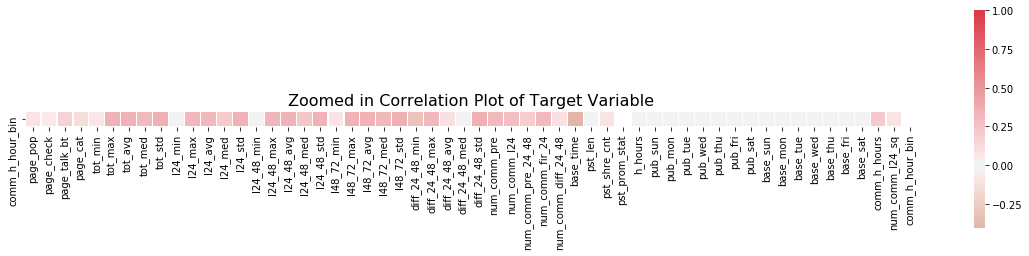

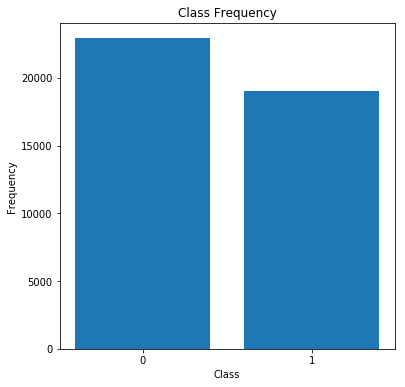

In [238]:
final_df.loc[:,['page_pop', 'page_talk_bt', 'tot_avg', 'l24_avg', 'l24_48_avg', 'l48_72_avg', 'pst_len', 'pst_shre_cnt', 'comm_h_hours']].corr(method='pearson')
corr = final_df.corr(method='pearson')
#corr['comm_h_hours'].sort_values(ascending=False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
ax.set_title('Correlation of all variables against all variables', fontsize = 16)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .8})


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 10, as_cmap=True)

ax.set_title("Zoomed in Correlation Plot of Target Variable", fontsize = 16)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr[-1:], mask=mask[-1:], cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.15, cbar_kws={"shrink": 1})

unique, counts = np.unique(final_df.comm_h_hour_bin, return_counts=True)
plt.figure(figsize = (6,6))
plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0,1], unique)
plt.show()

# Facebook Dataset Feature Scaling and PCA
1. We first split our data into a 70/30 split of training and test as this is what we've done in class
1. Afte split, we scale ours features. Scaling the features to make sure they are all on the same scale not only helps with computation time but also allows regularization to work properly
2. After we split and scale the data we then apply Principle Components Analysis to the data
 - We are applying PCA to our data as it accomplishes a couple of things:
  - it reduces our dimensions from 54 dimensions to 21 dimensions while still retaining 90% of the variance from our original data
  - how it performs this is by taking variables which are correlated to each other and turns them into uncorrelated variables called principle components
  - this is important as it will take less time to fit our model while still retaining the majority of the variance from our original data


In [21]:
x_train_fb, x_test_fb, y_train_fb, y_test_fb = train_test_split(X_fb, y_fb, test_size = .30, shuffle = True)

full_xscaler = StandardScaler().fit(x_train_fb)
x_train_scaled_fb = full_xscaler.transform(x_train_fb)
x_test_scaled_fb = full_xscaler.transform(x_test_fb)

In [22]:
pca = PCA(n_components=.90,random_state=20190301)
x_train_pca_fb = pca.fit_transform(x_train_scaled_fb)
x_test_pca_fb = pca.transform(x_test_scaled_fb)

In [23]:
x_train_pca_fb.shape

(29364, 21)

# Support Vector Machines Facebook - Linear Model - Experiment 1

### We are choosing to run a linear, RBF and polynomial model as these are some of the most popular SVM models


In [424]:
############################################################################################
#
# Grid search do not run just here to show how i did it and that it was done
# if you need to run open the csv file to see results
#
############################################################################################
cv = 6
grid_search_lin_fb = pd.DataFrame(columns = ['C', 'score','time', 'start_time'])
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
comp_time_svmfbl = np.zeros(shape=(len(param_range),2))
train_scores = np.zeros(shape=(len(param_range),cv))
test_scores = np.zeros(shape=(len(param_range),cv))

for row, i in enumerate(param_range):
    start = time()
    print(f'Working on {i}')
    svmclf_fb = svm.SVC(C = i, kernel = 'linear')
    svmclf_fb.fit(x_train_pca_fb,y_train_fb)
    train_scores[row,:] =cross_val_score(svmclf_fb,x_train_pca_fb,y_train_fb,cv = cv, n_jobs = 4)
    test_scores[row,:] =cross_val_score(svmclf_fb,x_test_pca_fb,y_test_fb,cv = cv, n_jobs = 4)
    end = time()
    comp_time_svmfbl[row,0] = end-start
    comp_time_svmfbl[row,1] = start
    grid_search_lin_fb = grid_search_lin_fb.append({'C': i,
                                'score': score,
                                'time':end-start,
                                'start_time':start
                               }, ignore_index=True)
    
#grid_search_lin_fb.to_csv('..\data\grid_search_lin_fb.csv', index=False)

Working on 0.001
Working on 0.01
Working on 0.1
Working on 1.0
Working on 10.0
Working on 100.0


## SVM - Linear Search Experiment 1 Results
1. Experiment 1 - Linear search of Facebook dataset what is the optimal C parameter?
 - Since we need to find the optimal C parameter we will loop over 6 values to see which provides us optimal scores
2. Experiment 1 results:
 - We find that any C value >=.1 provides a cross validated accuracy score which are equivalent to each other, meaning the accuracy of .1 is very similar to 1,10 and 100.
 - This is evident in both graph 1 and 2 below which shows the average of a 6 fold cross validation all have roughly a 79% accuracy on the training set and 81% accuracy on the test set

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

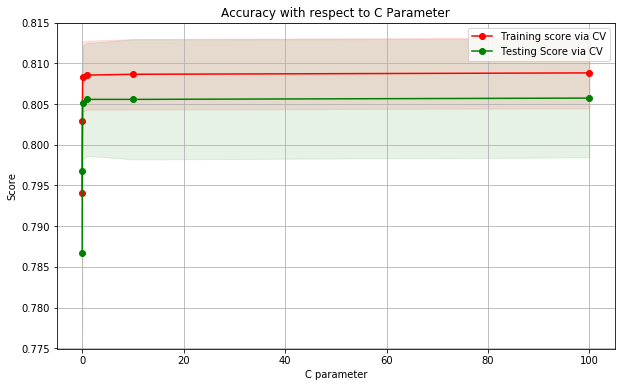

In [25]:
grid_search_lin_fb = pd.read_csv('..\data\grid_search_lin_fb.csv')
plot_learning_curves_nimb(param_range, train_scores, test_scores,xlabel='C parameter', title='Accuracy with respect to C Parameter')

Experiment 1 results Continued:
 - In the box &whiskey plot below you will see that C values between .1 thru 100 are nearly identical in their median(gold bar) and mean(green diamond). This process was done via 6 fold cross validation
 - Since the default parameter is 1 we are leaning towards choosing 1 but we need to determine if it suffers from high bias or high variance and take computation time into consideration

Text(0.5, 0, 'C Parameter Value')

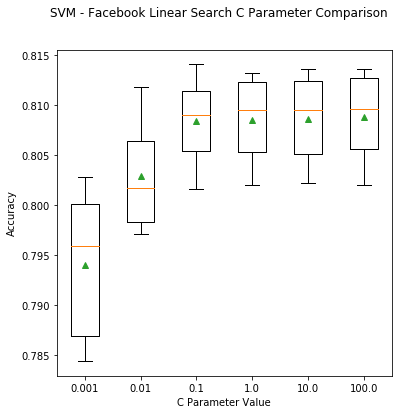

In [56]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
fig = plt.figure(figsize=(6,6))
fig.suptitle('SVM - Facebook Linear Search C Parameter Comparison')
ax = fig.add_subplot(111)
plt.boxplot(train_scores.T,showmeans=True,)
ax.set_xticklabels(param_range)
ax.set_ylabel('Accuracy')
ax.set_xlabel('C Parameter Value')

# Support Vector Machines - Linear Experiment 2

1. Experiment 2 - Computation time with respect to parameter

2. Experiment 2 Results:
 - C parameter <=1 takes roughly 1 min
 - C parameter 10 takes 7 mins and 100 takes 40 mins
 - as a reminder our definition of optimal was similar accuracy with low computation time, a C parameter of 1 fits this definition


Text(0.5, 0, 'C parameter')

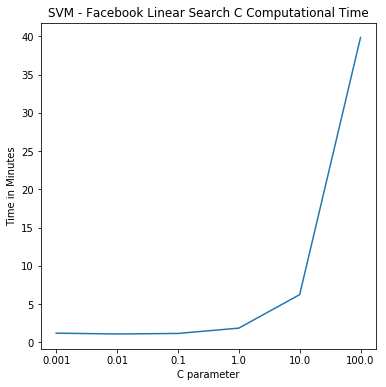

In [55]:
fig = plt.figure(figsize=(6,6))
plt.title('SVM - Facebook Linear Search C Computational Time')
plt.plot(comp_time_svmfbl[:,0]/60)
plt.xticks([0,1,2,3,4,5],param_range)
plt.ylabel('Time in Minutes')
plt.xlabel('C parameter')

# Support Vector Machines - Linear Experiment 3
1. Experiment 3 - Since the above showed we only anything .01 and above produced similar results we want to see which has the best bias/variance trade off. Please note we are not running a C parameter of 100 due to compatational time

2. Expierment Results:
 - Plot 1 C parameter .01 both training and testing CV accuracy score are still improving as m increases - this tells us our margin is too wide and is underfitting the model to start.
 - plot 2 C parameter 1 has low variance and low bias as m increases our training and CV converge - this is the model we will choose which is the default parameter
 - Plot 3 C parameter 10 has low variance and low bias as m increases our training and CV converge - this model also appears to work as well but we are choosing the default parameter becuase the default parameter takes 1min to fit while this takes 7mins to fit.
 
3. What is the C Parameter?
 - The C term is a regularization parameter it allows us to control maximizing the decision boundary margin with correct classification. As we increase C we are increasing the penalty of misclassification which results in a smaller margin. The smaller C parameter will allow for a wider margin and will have lower misclassification errors. This is our bias/variance control.  As a result, smaller C values will allow data points to enter into the margin. The goal of SVM is to create a linearly seperable hyperplace which perfectly fits our data while maximizing the margin between classes. In reality we seldom have a perfect seperation of classes, thus, the C parameter allows us a bias/variance tradeoff


#### In the linear SVM model we will choose the C parameter of 1 due to it obtaining high accuracy in cross validation and having one of the smallest computational times
 


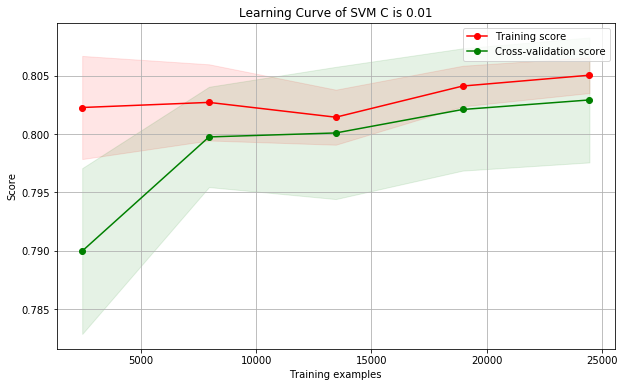

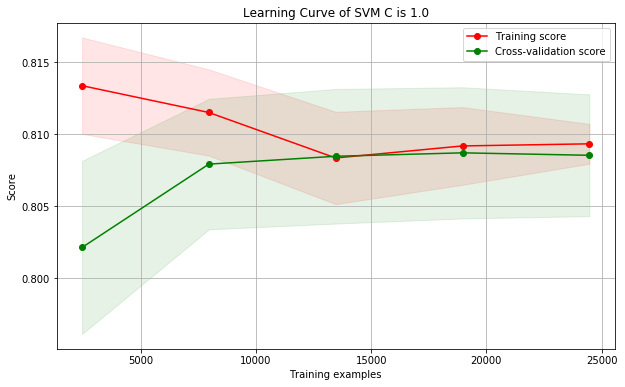

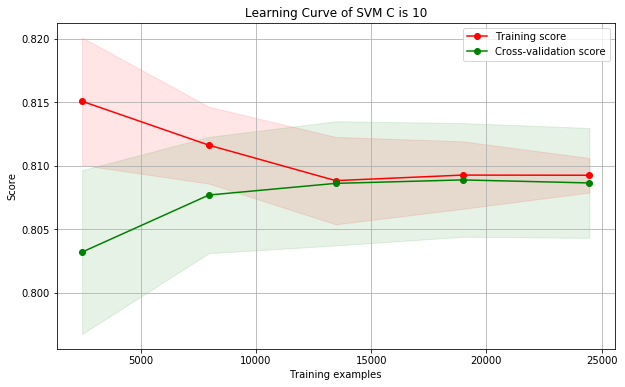

In [39]:
cv = 6
param_range = [0.01, 1.0, 10]

for i in param_range:
    svmclf_fb = svm.SVC(C = i, kernel = 'linear')
    svmclf_fb.fit(x_train_pca_fb,y_train_fb)
    plot_learning_curve(svmclf_fb,'Learning Curve of SVM C is %s' %i ,x_train_pca_fb, y_train_fb,cv = cv,n_jobs=4)

## Support Vector Machines RBF Facebook Dataset Experiment 1


In [143]:
#Experiment 1 RBF - Search of C and Gamma parameter
# Since we need to find the optimal C parameter we will loop over 5 values to see which provides us optimal scores at the same time we will loop over 10 gamma variables
# optimal scores will be defined by a balance of accuracy and computational time. We're willing to sacrifice a small amount of accuracy for computation time
# Based on our findings from the linear search we know our optimal range is between 1 and 10 so we are only looping over C values between 1 and 10
# Our gamma search space is 10 numbers between .0001 and .2 this was chosen after an initital round of results which showed values <.2 performing best

############################################################################################
#
# Grid search do not run just here to show how i did it and that it was done
# if you need to run open the csv file to see results
#
############################################################################################

cv = 5
grid_search_fbrbf = pd.DataFrame(columns = ['C', 'gamma', 'score','time', 'start_time'])
c_range = np.linspace(start = 1, stop = 10, num = 5)
gam_range = np.linspace(start = .001, stop = .2,num = 10)
comp_time_rbffb = np.zeros(shape=(len(gam_range),2))
train_scores_rbffb = np.zeros(shape=(len(gam_range),cv))
test_scores_rbffb = np.zeros(shape=(len(gam_range),cv))

for c in c_range:
    print(f'working on C value {c}')
    for row, g in enumerate(gam_range):
        print(f'working on {g}')
        start = time()
        svmclf = svm.SVC(C = c, kernel = 'rbf', gamma = g)
        svmclf.fit(x_train_pca_fb,y_train_fb)
        train_scores_rbffb[row,:] =cross_val_score(svmclf,x_train_pca_fb,y_train_fb,cv = cv, n_jobs = -1)
        test_scores_rbffb[row,:] =cross_val_score(svmclf,x_test_pca_fb,y_test_fb,cv = cv, n_jobs = -1)
        score = svmclf.score(x_test_pca_fb,y_test_fb)
        end = time()
        comp_time_rbffb[row,0] = (end-start)/60
        comp_time_rbffb[row,1] = start
        grid_search_fbrbf = grid_search_fbrbf.append({'C': c,
                                        'gamma': g,
                                        'score': score,
                                        'time':end-start,
                                        'start_time':start
                                       }, ignore_index=True)


working on C value 1.0
working on 0.001
working on 0.023111111111111114
working on 0.045222222222222226
working on 0.06733333333333334
working on 0.08944444444444445
working on 0.11155555555555556
working on 0.13366666666666668
working on 0.1557777777777778
working on 0.1778888888888889
working on 0.2
working on C value 3.25
working on 0.001
working on 0.023111111111111114
working on 0.045222222222222226
working on 0.06733333333333334
working on 0.08944444444444445
working on 0.11155555555555556
working on 0.13366666666666668
working on 0.1557777777777778
working on 0.1778888888888889
working on 0.2
working on C value 5.5
working on 0.001
working on 0.023111111111111114
working on 0.045222222222222226
working on 0.06733333333333334
working on 0.08944444444444445
working on 0.11155555555555556
working on 0.13366666666666668
working on 0.1557777777777778
working on 0.1778888888888889
working on 0.2
working on C value 7.75
working on 0.001
working on 0.023111111111111114
working on 0.0452

In [337]:
# create optimal calc and send to csv
grid_search_fbrbf = pd.read_csv('..\data\grid_search_rbf_tfb.csv')
grid_search_fbrbf['time_per_score'] = grid_search_fbrbf['time']/(grid_search_fbrbf['score']*100)
grid_search_fbrbf['time_per_score2'] = (grid_search_fbrbf['time']**(1/2))/((grid_search_fbrbf['score'])**4)
grid_search_fbrbf.sort_values(by='time_per_score2',ascending = True).head(1)
#grid_search_fbrbf.to_csv('..\data\grid_search_rbf_tfb.csv', index=False)

,C,gamma,score,time,start_time,time_per_score,time_per_score2
11,3.25,0.023111,0.812872,67.376393,1.552494e+09,0.828868,18.800276


## Support Vector Machines RBF Facebook Dataset - Experiment 1 Results

1. Experiment 1 results - Search of C and Gamma parameter
 - C value of 1 has the lowest accuracy rate of all the C parameters at each respective gamma parameter
 - C value between 3 - 10 have higher accuracy scores than C=1 across all gamma parameters and follow the same trend. Accuracy increases until gamma parameter .05 then begins to sequentially decrease


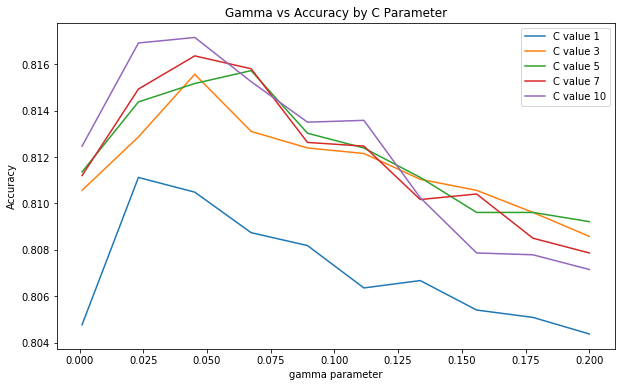

In [51]:
#sigma on the xaxis
#accuracy on the y axis
plt.figure(figsize = (10,6))
for i in set(grid_search_fbrbf.C):
    plt.title('Gamma vs Accuracy by C Parameter')
    plt.plot(grid_search_fbrbf[grid_search_fbrbf.C ==i]['gamma'],grid_search_fbrbf[grid_search_fbrbf.C ==i]['score'], label = 'C value %i' % i)
    plt.xlabel('gamma parameter')
    plt.ylabel('Accuracy')
    plt.legend()

## Support Vector Machines RBF Facebook Dataset - Experiment 2 Time per Score

1. Experiment 2 results - Find lowest time per score
 - time per score is how we are defining optimal model. We want models which are accurate and take the shortest amount of time to compute
   - we raise accuracy to the 4th power and take the sqrt of time. This skews our results to models which are more accurate but may take 5-10 seconds longer.
 - the higher the value on the chart the less optimal it is. Higher values mean it's taking longer to achieve scores which may be similar or slighly higher.
 - One must weight the computationtal time when running models
 - The optimal scores have a gamma value of .025 for all C parameters
 - The optimal model as defined above is C= 3.25 and gamma = .023


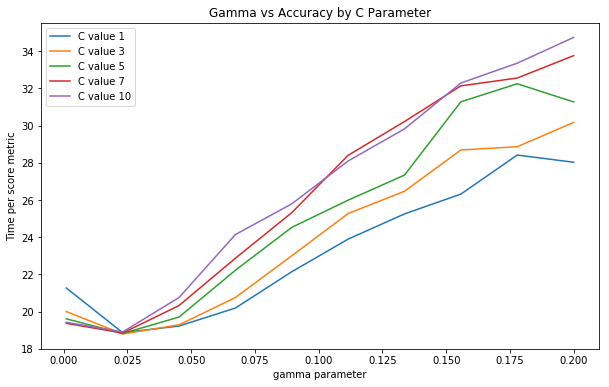

In [335]:
plt.figure(figsize = (10,6))
for i in set(grid_search_fbrbf.C):
    plt.title('Gamma vs Accuracy by C Parameter')
    plt.plot(grid_search_fbrbf[grid_search_fbrbf.C ==i]['gamma'],grid_search_fbrbf[grid_search_fbrbf.C ==i]['time_per_score2'], label = 'C value %i' % i)
    plt.xlabel('gamma parameter')
    plt.ylabel('Time per score metric')
    plt.legend()

## Support Vector Machines RBF Facebook Dataset - Experiment 3 - Bias/Variances of Optimal Model

1. Experiment 2  - Bias/Variance of optimal model (see previous experiment for definition)
  
2. Experiment 2  - Bias/Variance of optimal model - Results
 - Our optimal model shows that as m increases the training and cross validation accuracy moves closer towards convergence. This is indicitive of a model which has low bias/low variance due to their convergence.

#### In the end we will choose a C value of 3.25 and a gamma value of .0231 as this is our optimal model and has low bias/low variance

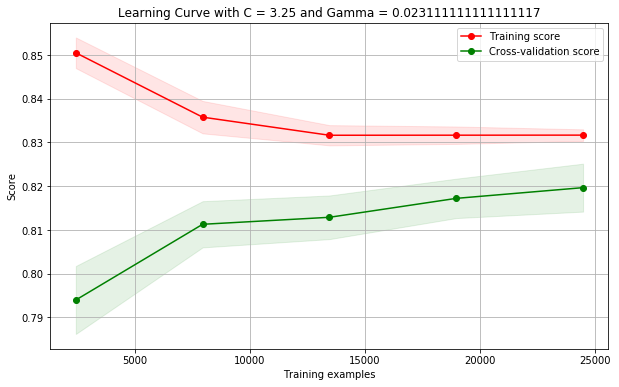

In [336]:
top_n_rbf_fb = grid_search_fbrbf.sort_values(by='time_per_score2', ascending = True).reset_index(drop=True).head(1)

for i in range(0,len(top_n_rbf_fb)):
    c = top_n_rbf_fb.loc[i,'C']
    gam = top_n_rbf_fb.loc[i,'gamma']
    svmclf_rbf = svm.SVC(C = c, kernel = 'rbf', gamma = gam)
    svmclf_rbf.fit(x_train_pca_fb,y_train_fb)
    plot_learning_curve(svmclf_rbf,title = f'Learning Curve with C = {c} and Gamma = {gam}',X= x_train_pca_fb,y= y_train_fb,cv = 6,n_jobs = -1)

# Support Vector Machines  - Polynominal Experiment 1


In [23]:
############################################################################################
#
# Grid search do not run just here to show how i did it and that it was done
# if you need to run open the csv file to see results
#
############################################################################################

grid_search_fbp_df = pd.DataFrame(columns = ['degrees','C', 'gamma', 'score','time', 'start_time'])
c_range = [1,3,5,10]
gamma_space = np.linspace(start = .001, stop=0.05, num = 10)
degrees = [3,4,5,6]

for d in degrees:
    print(f'working on {d} degrees')
    for c in c_range:
        print(f'working on {c} C')
        for gam in gamma_space:
            print(f'Working on {gam} gamma')
            start = time()
            svmclf = svm.SVC(C = c, kernel = 'poly',degree=d, gamma = gam)
            svmclf.fit(x_train_pca_fb,y_train_fb)
            score = svmclf.score(x_test_pca_fb,y_test_fb)
            end = time()
            grid_search_fbp_df = grid_search_fbp_df.append({'degrees': d,
                                                    'C': c,
                                                    'gamma': gam,
                                                    'score': score,
                                                    'time':end-start,
                                                    'start_time':start
                                                   }, ignore_index=True)

working on 3 degrees
working on 1 C
Working on 0.001 gamma
Working on 0.0064444444444444445 gamma
Working on 0.01188888888888889 gamma
Working on 0.017333333333333333 gamma
Working on 0.02277777777777778 gamma
Working on 0.028222222222222225 gamma
Working on 0.033666666666666664 gamma
Working on 0.03911111111111111 gamma
Working on 0.04455555555555556 gamma
Working on 0.05 gamma
working on 3 C
Working on 0.001 gamma
Working on 0.0064444444444444445 gamma
Working on 0.01188888888888889 gamma
Working on 0.017333333333333333 gamma
Working on 0.02277777777777778 gamma
Working on 0.028222222222222225 gamma
Working on 0.033666666666666664 gamma
Working on 0.03911111111111111 gamma
Working on 0.04455555555555556 gamma
Working on 0.05 gamma
working on 5 C
Working on 0.001 gamma
Working on 0.0064444444444444445 gamma
Working on 0.01188888888888889 gamma
Working on 0.017333333333333333 gamma
Working on 0.02277777777777778 gamma
Working on 0.028222222222222225 gamma
Working on 0.03366666666666666

In [24]:
#grid_search_fbp_df.to_csv('..\data\grid_search_fbp_df.csv', index=False)

In [426]:
grid_search_fbp_df = pd.read_csv('..\data\grid_search_fbp_df.csv')
# create time per score and sort
grid_search_fbp_df['time_per_score'] = grid_search_fbp_df['time']/(grid_search_fbp_df['score']*100)
grid_search_fbp_df['time_per_score2'] = (grid_search_fbp_df['time']**(1/2))/((grid_search_fbp_df['score'])**4)
grid_search_fbp_df.sort_values(by='time_per_score2',ascending = True).head()

,degrees,C,gamma,score,time,start_time,time_per_score,time_per_score2
32,3.0,10.0,0.011889,0.789670,27.862150,1.552542e+09,0.352833,13.574512
22,3.0,5.0,0.011889,0.781486,26.469852,1.552541e+09,0.338712,13.794030
4,3.0,1.0,0.022778,0.784664,27.963100,1.552541e+09,0.356370,13.949451
23,3.0,5.0,0.017333,0.793008,30.772237,1.552541e+09,0.388045,14.027176
13,3.0,3.0,0.017333,0.788478,29.398464,1.552541e+09,0.372851,14.028242


# Support Vector Machines  - Polynominal Experiment 1 Results

1. Experiment 1 Polynominal - Results - accuracy vs computation time
 - Across all degrees and C parameter values, a gamma parameter between .01 and .025 has the lowest time per score
 - As the degrees of polynomials increase not only does our complexity increase but the computation time to get similar scores increases as well
 - the best time per score variable is degrees = 3, C = 10 and gamma = .01189
 

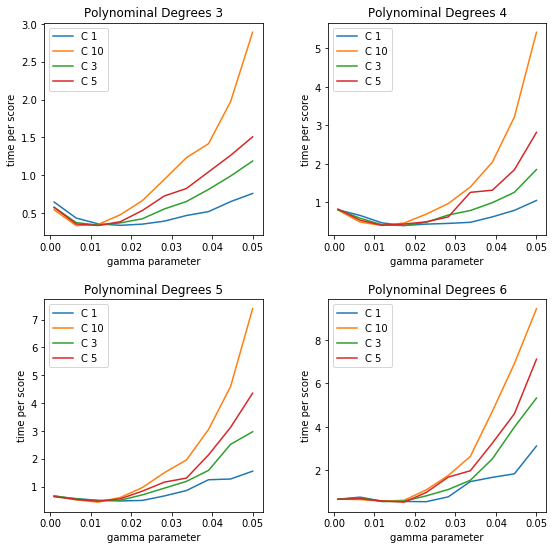

In [429]:
fig = plt.figure(figsize = (9,9))
fig.subplots_adjust(hspace=.3, wspace=.3)
for i in range(1, 5):
    dat = grid_search_fbp_df[grid_search_fbp_df.degrees == i+2]
    ax = fig.add_subplot(2, 2,i)
    #ax = fig.subplots(2,2,i,sharex = 'col',sharey='row')
    dval = i+2
    #ax.text(0.5, 0.5, str((2, 2, i)),fontsize=18, ha='center')
    for c in set(dat.C):
        ax.set_title('Polynominal Degrees %i' % dval)
        ax.plot(dat[dat.C ==c]['gamma'],dat[dat.C ==c]['time_per_score'], label = 'C %i' % c)
        ax.legend()
        ax.set_ylabel('time per score')
        #ax.set_ylim(bottom =0.56, top=.82)
        #ax.set_ylim(bottom =0, top=10)
        ax.set_xlabel('gamma parameter')

In [354]:
grid_search_fbp_df.sort_values(by='time_per_score2',ascending = True).head(1)

,degrees,C,gamma,score,time,start_time,time_per_score,time_per_score2
32,3.0,10.0,0.011889,0.78967,27.86215,1.552542e+09,0.352833,13.574512


# Support Vector Machines  - Polynominal Experiment 2 Learning Curve of Optimal Model

1. Experiment 2 Polynominal - Learning curve of optimal mode
 - Optimal model is defined as sqrt(time) divided by score ^4. We wanted to weight accuracy more. We're willing to accept something that's a couple of seconds slower if it improves accuracy.

1. Experiment 2 Polynominal - Learning curve of optimal model results
 - As m increase the training accuracy and CV accuracy begin to converge. This is indicitive of low bias/low variance
 
#### Our best Poly model is C=10, degree = 3 and gamma = .011889

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

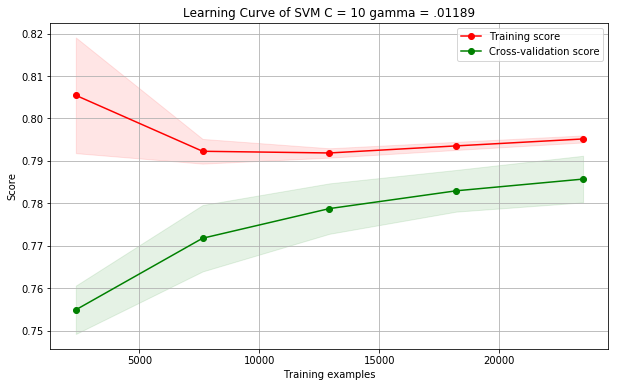

In [356]:
svmclf = svm.SVC(C = 10, kernel = 'poly',degree=3, gamma = .011889)
svmclf.fit(x_train_pca_fb,y_train_fb)
plot_learning_curve(svmclf,f'Learning Curve of SVM C = 10 gamma = .01189',x_train_pca_fb, y_train_fb,cv = 5,n_jobs=-1)

In [357]:
fb_svm_results = []
cv = 9

#Best Linear Model
svmfb_lin = svm.SVC(C = 1, kernel = 'linear',probability = True)
svmfb_lin.fit(x_train_pca_fb,y_train_fb)
fb_svm_results.append(cross_val_score(svmfb_lin, x_test_pca_fb, y_test_fb, cv=cv,n_jobs=-1, scoring='accuracy'))

#Best RBF Model
svmclf_rbf = svm.SVC(C = 3.25, kernel = 'rbf', gamma = .0231,probability = True)
svmclf_rbf.fit(x_train_pca_fb,y_train_fb)
fb_svm_results.append(cross_val_score(svmclf_rbf, x_test_pca_fb, y_test_fb, cv=cv,n_jobs=-1, scoring='accuracy'))

#Best Poly Model
svmclf_ply = svm.SVC(C = 10, kernel = 'poly',degree=3, gamma = .011889,probability = True)
svmclf_ply.fit(x_train_pca_fb,y_train_fb)
fb_svm_results.append(cross_val_score(svmclf_ply, x_test_pca_fb, y_test_fb, cv=cv,n_jobs=-1, scoring='accuracy'))


# SVM - Facebook Final Model Comparison Continued

1. we chose linear, rbf and poly as these are the most popular SVMs
1. When comparing the three we see that linear and RBF models have similar accuracies (top plot) and accuracy distributions which overlap each other.
1. When looking at the ROC curve(bottom plot) the RBF is the clear winner with a ROC/AUC score of 89%. The RBF hugs the upper left of the chart(bottom plot) the best.
1. In regards to computational time, RBF does take 1 min to fit while linear takes 2 seconds to fit. I'm willing to accept something that takes a little bit longer in the case given our ROC gains.

We conclude the RBF SVM models is the best as the orange line below in the ROC curve is closer to the top left of the ROC Curve.

#### We conclude our best model to be the RBF SVM model with parameters C=3.25 and gamma = .0231

linear had an auc score of 0.878381139908269
rbf had an auc score of 0.8909549050062873
poly had an auc score of 0.8701312440184961


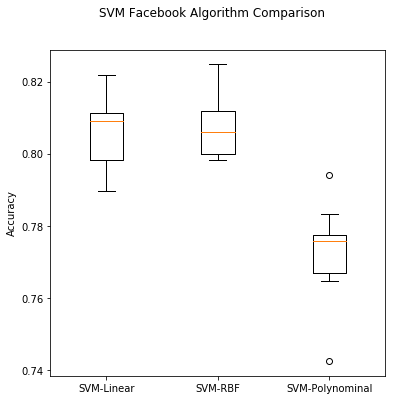

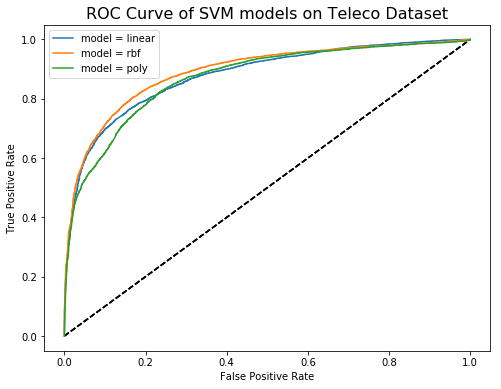

In [358]:
#Plot a box plot of the best results
my_names = ['SVM-Linear', 'SVM-RBF','SVM-Polynominal']
fig = plt.figure(figsize=(6,6))
fig.suptitle('SVM Facebook Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(fb_svm_results)
ax.set_xticklabels(my_names)
ax.set_ylabel('Accuracy')

#Plot the ROC curves
models = {'linear': svmfb_lin, 'rbf': svmclf_rbf,'poly':svmclf_ply}
plt.figure(figsize = (8,6))
for leg, model in models.items():
    fpr, tpr, _ = roc_curve(y_test_fb, model.predict_proba(x_test_pca_fb)[:,1])
    plt.title('ROC Curve of SVM models on Facebook Dataset', fontsize = 16)
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label = f'model = {leg}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

#ROC AUC Scores
for leg, model in models.items():
    auc_score = roc_auc_score(y_test_fb, model.predict_proba(x_test_pca_fb)[:,1])
    print(f'{leg} had an auc score of {auc_score}')

# Decision Trees for Facebook - Experiment 1 

#### Experiment 1 - Pruning the tree
1. Which depth value of the tree gives us an optimal accuarcy score?
 - optimal is defined by highest accurary while still being able to generalize (i.e. low bias/low variance). Computation time and tree depth are synonyms with each other therefore shorter trees take less time to fit

#### Conclusion
 - As depth increase boths training and testing accuracy increase up until a depth of 6 where testing accuracy and training accuracy diverge from each other. 
 - As the depth of the tree goes past 7 our decision tree is getting too deep and is overfitting
#### In the end we will change the max depth to 6

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

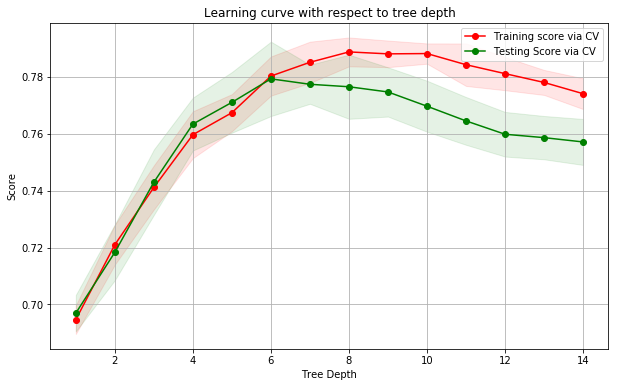

In [430]:
cv = 9
depth_range = range(1,15)
train_scores = np.zeros(shape=(len(depth_range),cv))
test_scores = np.zeros(shape=(len(depth_range),cv))

for row, i in enumerate(depth_range):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(x_train_pca_fb,y_train_fb)
    train_scores[row,:] =cross_val_score(clf,x_train_pca_fb,y_train_fb,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(clf,x_test_pca_fb,y_test_fb,cv = cv, n_jobs = -1)
    
plot_learning_curves_nimb(depth_range, train_scores, test_scores, title='Learning curve with respect to tree depth', xlabel='Tree Depth')

# Decision Trees for Facebook - Experiment 2

#### Experiment 2 - learning curve for our pruned tree(max depth =6)
1. Does our findings above conclude that we have a model which deals with the bias/variance trade off

#### Conclusion
 - Yes, we can conclude we have low bias/ low variance with our depth estimates
 - As m increases our training and testing accuracy converge. When m is at max our accuracy gap is within 2ppts of each other
 
#### In the end we will leave this hyperparameter at the default value

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

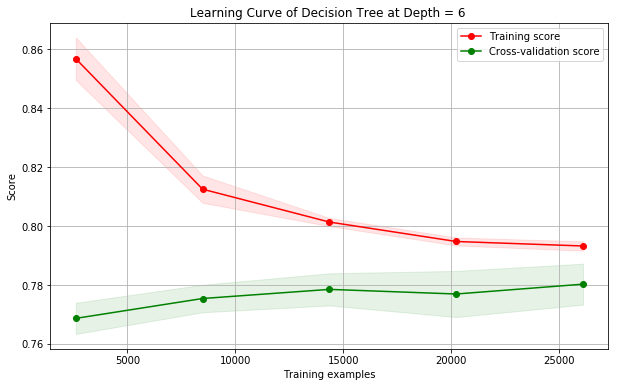

In [204]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf.fit(x_train_pca_fb,y_train_fb)
plot_learning_curve(clf,'Learning Curve of Decision Tree at Depth = 6 ',x_train_pca_fb, y_train_fb, cv=9,n_jobs=-1)

# Decision Trees for Facebook - Experiment 3

#### Experiment 3 - Minimum number of Samples per leaf
1. how does the minimum number of samples per leaf effect our accuracy?

#### Conclusion
 - The minimum number of samples per leaf does not have an effect on accuracy
 - Training error and testing error achieve a consistent accuracy(78%) as min samples per leaf increase
 
#### In the end we will leave this hyperparameter at the default value of 5

In [205]:
cv = 9
min_features = range(1,100,10)
#min_features = np.linspace(.0001,.1,num = 30)
train_scores = np.zeros(shape=(len(min_features),cv))
test_scores = np.zeros(shape=(len(min_features),cv))

for row, i in enumerate(min_features):
    clf = tree.DecisionTreeClassifier(max_depth=6,min_samples_leaf=i,random_state = 20190301)
    clf.fit(x_train_pca_fb,y_train_fb)
    train_scores[row,:] =cross_val_score(clf,x_train_pca_fb,y_train_fb,cv = cv, n_jobs = 4)
    test_scores[row,:] =cross_val_score(clf,x_test_pca_fb,y_test_fb,cv = cv, n_jobs = 4)

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

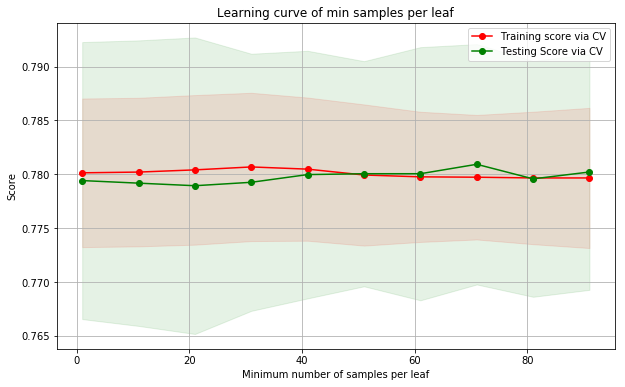

In [206]:
plot_learning_curves_nimb(min_features, train_scores, test_scores, xlabel='Minimum number of samples per leaf',title='Learning curve of min samples per leaf')

# Decision Trees for Telco - Experiment 4

#### Experiment 4 - Maximum Features
1. how does the max features affect the accuracy of our classification and how is the bias/variance trade off?

#### Conclusion
 - As we add more features up to the maximum number of dimenson in our dataset, accuracy improves
 - This makes sense as we used PCA to reduce the dimensonality of our data while maintaining 90% of the variance of the original data
 
#### In the end the default parameter of all variables is choosen

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

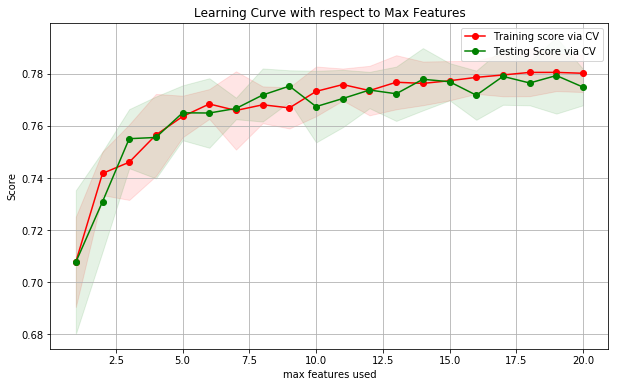

In [207]:
cv = 9

max_feature_range = range(1, x_train_pca_fb.shape[1])
train_scores = np.zeros(shape=(len(max_feature_range),cv))
test_scores = np.zeros(shape=(len(max_feature_range),cv))

for row, i in enumerate(max_feature_range):
    clf = tree.DecisionTreeClassifier(max_depth=6,max_features=i)
    clf.fit(x_train_pca_fb,y_train_fb)
    train_scores[row,:] =cross_val_score(clf,x_train_pca_fb,y_train_fb,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(clf,x_test_pca_fb,y_test_fb,cv = cv, n_jobs = -1)

plot_learning_curves_nimb(max_feature_range, train_scores, test_scores,xlabel='max features used', title='Learning Curve with respect to Max Features')

# Decision Trees for Telco - Experiment 5 - Gini vs Entropy

#### Experiment 5 - Does Gini impurity or Entropy give us better out of fit error
1. We want to pick the criterion that maximizes the classification accuracy

#### Conclusion
 - Based on the below chart, Gini impurity 9 fold mean accuracy = 77%, entropy 9 fold mean accuracy  = 77%. Both produce equal accuracy
 - since both are the same we are choosing the default value of gini impurity as it's the default

Text(0, 0.5, 'Accuracy')

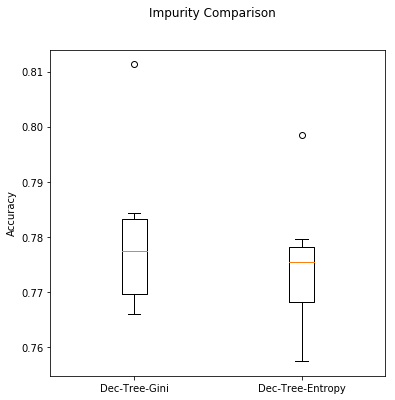

In [210]:
clf_crit_fb = []
cv = 9
#gini
clf_g_fb = tree.DecisionTreeClassifier(max_depth=6,criterion='gini')
clf_g_fb.fit(x_train_pca_fb,y_train_fb)
clf_crit_fb.append(cross_val_score(clf_g_fb,  x_test_pca_fb, y_test_fb,cv=cv,n_jobs=-1, scoring='accuracy'))

#entropy
clf_ent_fb = tree.DecisionTreeClassifier(max_depth=6,criterion='entropy')
clf_ent_fb.fit(x_train_pca_fb,y_train_fb)
clf_crit_fb.append(cross_val_score(clf_ent_fb, x_test_pca_fb, y_test_fb,cv=cv,n_jobs=-1, scoring='accuracy'))

#Plot the best results
my_names = ['Dec-Tree-Gini','Dec-Tree-Entropy']
fig = plt.figure(figsize=(6,6))
fig.suptitle('Impurity Comparison')
ax = fig.add_subplot(111)
plt.boxplot(clf_crit_fb)
ax.set_xticklabels(my_names)
ax.set_ylabel('Accuracy')

# Boosting (Adaboost) for Facebook - Experiment 1 

#### Experiment 1 - Base estimator param search
1. Which base estimator value of the boosted tree gives us an optimal accuarcy score?
 - optimal is defined by highest accurary while still being able to generalize (i.e. low bias/low variance)
 - we approach this by looping over several estimators and perform 9 fold cross validation

#### Conclusion
 - we conclude the 100 estimator to be optimal
     - Accuracy begins to increase up to estimator value of 100 at which both training and testing accuracy begin to diverge from each other and level out. 
     - Computation time increases linearly as we increase the number of estimators. Computation time with at 100 is 2 seconds and at 150 is 3 seconds. 

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

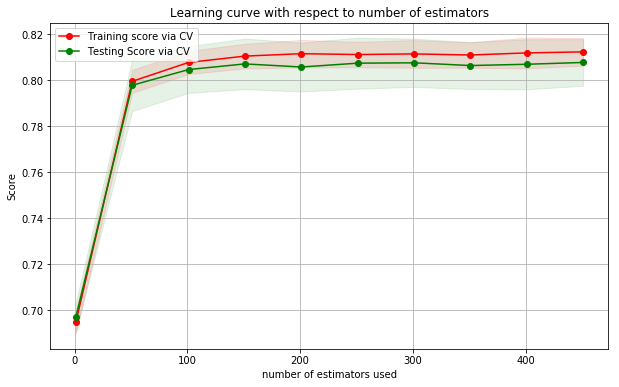

In [362]:
cv = 9
ada_estimator = range(1,500,50)
train_scores = np.zeros(shape=(len(estimator),cv))
test_scores = np.zeros(shape=(len(estimator),cv))
comp_time_ada = np.zeros(shape=(len(estimator),2))

for row, i in enumerate(ada_estimator):
    start = time()
    adaclf = AdaBoostClassifier(n_estimators=i)
    adaclf.fit(x_train_pca_fb, y_train_fb)
    train_scores[row,:] =cross_val_score(adaclf,x_train_pca_fb,y_train_fb,cv = cv, n_jobs = -1)
    test_scores[row,:] =cross_val_score(adaclf,x_test_pca_fb,y_test_fb,cv = cv, n_jobs = -1)
    end = time()
    comp_time_ada[row,0] = (end-start)/60
    comp_time_ada[row,1] = start

plot_learning_curves_nimb(estimator, train_scores, test_scores,xlabel='number of estimators used', title='Learning curve with respect to number of estimators')

Text(0, 0.5, 'estimation time in seconds')

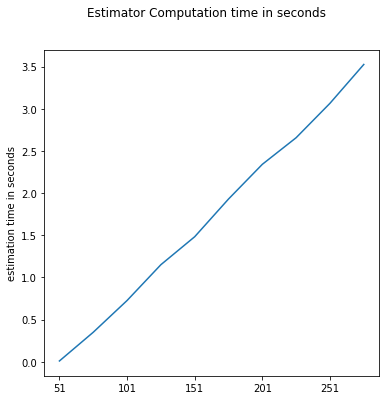

In [397]:
fig = plt.figure(figsize=(6,6))
fig.suptitle('Estimator Computation time in seconds')
ax = fig.add_subplot(111)
plt.plot(comp_time_ada[:,0])
ax.set_xticklabels(ada_estimator)
ax.set_ylabel('estimation time in seconds')

# Boosting (Adaboost) for Facebook - Experiment 2

#### Experiment 1 - Best estimator learning curve
1. Does Base estimator achieve low bias/low variance?

#### Conclusion
 - Yes, as m increases training and testing accuracy score converges. This displays low bias/low variance

### Our optimal model has an estimator of 100

<module 'matplotlib.pyplot' from 'c:\\users\\josh\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

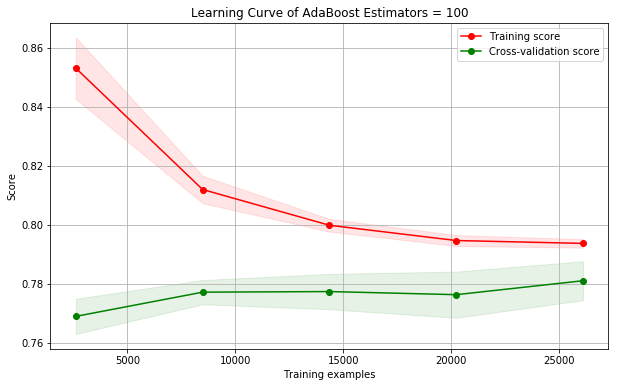

In [390]:
adaclf = AdaBoostClassifier(n_estimators=100)
adaclf.fit(x_train_pca_fb,y_train_fb)
plot_learning_curve(clf,'Learning Curve of AdaBoost Estimators = 100',x_train_pca_fb, y_train_fb, cv=9,n_jobs=-1)

In [392]:
cv = 9
fb_all_model_results = []

#Best Linear Model
svmfb_lin_fb = svm.SVC(C = 1, kernel = 'linear',probability = True)
svmfb_lin_fb.fit(x_train_pca_fb,y_train_fb)
fb_all_model_results.append(cross_val_score(svmfb_lin_fb, x_test_pca_fb, y_test_fb, cv=cv,n_jobs=-1, scoring='accuracy'))

#Best RBF Model
svmclf_rbf_fb = svm.SVC(C = 3.25, kernel = 'rbf', gamma = .0231,probability = True)
svmclf_rbf_fb.fit(x_train_pca_fb,y_train_fb)
fb_all_model_results.append(cross_val_score(svmclf_rbf_fb, x_test_pca_fb, y_test_fb, cv=cv,n_jobs=-1, scoring='accuracy'))

#Best Poly Model
svmclf_ply_fb = svm.SVC(C = 10, kernel = 'poly',degree=3, gamma = .011889,probability = True)
svmclf_ply_fb.fit(x_train_pca_fb,y_train_fb)
fb_all_model_results.append(cross_val_score(svmclf_ply_fb, x_test_pca_fb, y_test_fb, cv=cv,n_jobs=-1, scoring='accuracy'))

#best Decision tree
clf_dt_p_fb = tree.DecisionTreeClassifier(max_depth=6)
clf_dt_p_fb.fit(x_train_pca_fb,y_train_fb)
fb_all_model_results.append(cross_val_score(clf_dt_p_fb,  x_test_pca_fb, y_test_fb,cv=cv,n_jobs = -1, scoring='accuracy'))

#best Boosted Tree
adaclf_fb = AdaBoostClassifier(n_estimators=100)
adaclf_fb.fit(x_train_pca_fb, y_train_fb)
fb_all_model_results.append(cross_val_score(adaclf_fb,  x_test_pca_fb, y_test_fb,cv=cv,n_jobs = -1,  scoring='accuracy'))


# Final Facebook Data Standoff

#### In the end we would choose the ADABoost model as the best model.

1. Reasons for picking this model
 - The accuracy between ADAboost, SVM-Linear and SVM-RBF are all comperable to each other and their accuracy distributions overlap each other. This means they are all roughly equal
 - ADABoost has the second highest AUC score at 88% right below SVM-RBF at 89.1%. While Adaboost had a 1ppt lower ROC score it is much faster to compute than SVM-RBF
   - ADABoost takes 1 second to fit while SVM-RBF takes roughly 70 seconds to fit.
   - At the end of the day we need to choose a model that's both accurate and computationally cheap. ADABoost fits both of those criteria


Text(0, 0.5, 'Accuracy')

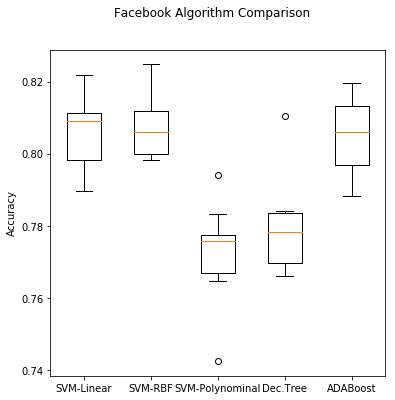

In [393]:
#Plot the best results
my_names = ['SVM-Linear', 'SVM-RBF','SVM-Polynominal', 'Dec.Tree','ADABoost']
fig = plt.figure(figsize=(6,6))
fig.suptitle('Facebook Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(fb_all_model_results)
ax.set_xticklabels(my_names)
ax.set_ylabel('Accuracy')

linear-SVM had an auc score of 0.8783827554995236
rbf-SVM had an auc score of 0.890957004002799
poly-SVM had an auc score of 0.870126804322844
Dec.Tree had an auc score of 0.8587315939631944
Adaboost had an auc score of 0.8835204756219238


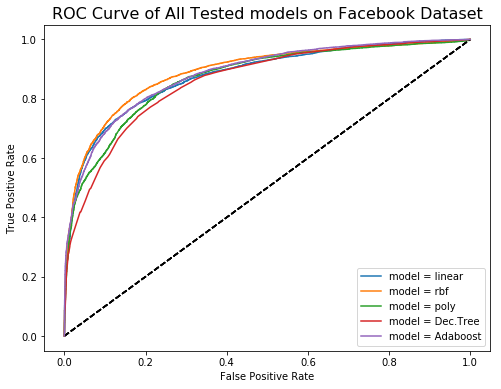

In [437]:
models = {'linear': svmfb_lin_fb, 'rbf': svmclf_rbf_fb,'poly':svmclf_ply_fb,'Dec.Tree':clf_dt_p_fb,'Adaboost':adaclf_fb}
plt.figure(figsize = (8,6))
for leg, model in models.items():
    fpr, tpr, _ = roc_curve(y_test_fb, model.predict_proba(x_test_pca_fb)[:,1])
    plt.title('ROC Curve of All Tested models on Facebook Dataset', fontsize = 16)
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label = f'model = {leg}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

models = {'linear-SVM': svmfb_lin_fb, 'rbf-SVM': svmclf_rbf_fb,'poly-SVM':svmclf_ply_fb,'Dec.Tree':clf_dt_p_fb,'Adaboost':adaclf_fb}
for leg, model in models.items():
    auc_score = roc_auc_score(y_test_fb, model.predict_proba(x_test_pca_fb)[:,1])
    print(f'{leg} had an auc score of {auc_score}')

# Final Discussion

## Telco Dataset Final Model 
 1. Optimal model was SVM-Linear. This was choosen because it has the highest AUC score, 83.5%, has an 80% accuracy rate and takes 2.65 seconds to fit. The combination of these 3 make it the optimal model.
 
## Facebook Dataset Final Model 
 1. Optimal model was Adaboost . This was choosen because it has a good accuracy score 81% via 9-fold CV and is computationally cheap as in it takes seconds to fit
 
### Challenges experienced Overall
1. computation time - grid searching these values took a lot of time to get correct

### Steps that could have been taken to get better overall results
1. feature engineering - i wish I could have spent more time feature engineering and less time optimizing the models. I believe feature engineering is an ofter overlooked step that has the ability to vastly improve models


 